These notes are structured as an iPython/Jupyter notebook tutorial written in python 3, and depend only on the numpy and scipy libraries. [download as: [.ipynb](https://michaelerule.github.io/publications/notes/cambridge%20notes/20200512_mrule_GP_for_grid_cells.ipynb), [.html](https://michaelerule.github.io/publications/notes/cambridge%20notes/20200512_mrule_GP_for_grid_cells.html), [.pdf](https://michaelerule.github.io/publications/notes/cambridge%20notes/20200512_mrule_GP_for_grid_cells.pdf)]


# Applying Gaussian process models to hippocampal grid cell data

[Gaussian Processes (GPs)](https://en.wikipedia.org/wiki/Gaussian_process) generalize the idea of multivariate Gaussian distributions to distributions over functions. In neuroscience, they can be used to estimate how the firing rate of a neuron varies as a function of other variables (e.g. to [track retinal waves](https://mrule-intheworks.blogspot.com/2019/02/neural-field-models-for-latent-state.html)). Lately, we've been using Gaussian processes to describe the firing rate map of [hippocampal grid cells](https://en.wikipedia.org/wiki/Grid_cell). 

We review Bayesian inference and Gaussian processes, explore applications of Gaussian Processes to analyzing grid cell data, and finally construct a GP model of the log-rate that accounts for the Poisson noise in spike count data. Along the way, we discuss fast approximations for these methods, like [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation), or approximating GP inference using convolutions. 

# Introduction

First, we briefly review Bayesian inference for multivariate Gaussian variables and Gaussian processes. Then, we construct some synthetic spike-count observations, similar to what one might see in hippocampal grid cells. We then review how to estimate the underlying firing rate map using kernel density estimation, and discuss some regularization choices when data are limited. 

### Bayesian inference in multivariate Gaussian distributions

Loosely, Gaussian processes can be viewed as "really big" multivariate Gaussian distributions, with infinitely many variables. It's helpful to review Bayesian inference for multivariate Gaussian variables before continuing. 

Consider estimating some jointly Gaussian variables $z$ from observations $y$. Bayes' rule states that the posterior distribution $\Pr(z|y)$ is proportional to our prior, $\Pr(z)$, times the likelihood of observing $y$ given $z$, $\Pr(y|z)$:

\begin{equation}
\Pr(z|y) \propto \Pr(y|z) \Pr(z).
\end{equation}

Consider a case where both $\Pr(y|z)$ and $\Pr(z)$ are Gaussian:

\begin{equation}
\begin{aligned}
\Pr(z) &= \mathcal N( \mu_0, \Sigma_0 )
\\
\Pr(z|y) &= \mathcal N( y,  \Sigma_\epsilon )
\end{aligned}
\end{equation}

We can estimate $\Pr(z|y)$ using Bayes' rule, by multiplying these two probability distributions (and normalizing the result to integrate to one). 

$$
\begin{aligned}
\Pr(y|z) \Pr(z) &\propto 
\exp\left[-\tfrac 1 2 (z-\mu_0)^\top\Sigma_0^{-1}(z-\mu_0)\right]
\exp\left[-\tfrac 1 2 (z-y)^\top\Sigma_\epsilon^{-1}(z-y)\right]
\\&\propto
\exp\left\{-\tfrac 1 2 
\left[
z^\top\Sigma_0^{-1}z
-2z^\top\Sigma_0^{-1}\mu_0
+
z^\top\Sigma_\epsilon^{-1}z
-2z^\top\Sigma_\epsilon^{-1}y
\right]
\right\}
\\&=
\exp\left\{-\tfrac 1 2 
\left[
z^\top(\Sigma_0^{-1}+\Sigma_\epsilon^{-1})z
-2z^\top(\Sigma_0^{-1}\mu_0+\Sigma_\epsilon^{-1}y)
\right]
\right\}
\\&=
\exp\left\{-\tfrac 1 2 
\left[
z^\top\Sigma^{-1}z
-2z^\top\Sigma^{-1}\mu
\right]
\right\}
\\&\propto
\exp\left\{-\tfrac 1 2 (z-\mu)^\top\Sigma^{-1}(z-\mu)
\right\}
\end{aligned}
$$

This product of two multivariate Gaussian distributions is also a multivariate Gaussian distribution, $\hat z \sim \mathcal N(\mu, \Sigma)$, with covariance and mean: 

\begin{equation}
\begin{aligned}
\Sigma 
&= \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}
\\
\mu
&= \Sigma \left[\Sigma_0^{-1}\mu_0 + \Sigma_\epsilon^{-1}y \right] 
\end{aligned}
\end{equation}

In other textbooks or tutorials, you might also see this written as 

\begin{equation}
\begin{aligned}
\Sigma 
&= \Sigma_0 - \Sigma_0[\Sigma_0 + \Sigma_\epsilon]^{-1} \Sigma_0
\\
\mu
&= \mu_0 
+ \Sigma_0\left[\Sigma_\epsilon + \Sigma_0 \right]^{-1}(y-\mu_0).
\\
\end{aligned}
\end{equation}

Both forms are equivalent, and are related to each other by applying the [Sherman–Morrison–Woodbury matrix inversion lemma](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).

### Gaussian process regression

Gaussian processes are commonly used to estimate a smooth underlying trend from noisy observations. [Peter Roelants'](https://peterroelants.github.io/posts/gaussian-process-tutorial/) notes on Gaussian processes is a clear and detailed introduction. 

Consider a GP regression problem for learning $y=f(\mathbf x)$, where $\mathbf x=\{x_1,x_2\}$ are coordinates in 2D. Here, our prior over functions is specified not by a mean and covariance, but by a mean function $m(\mathbf x)$ and a two-point correlation function $\kappa(\mathbf x,\mathbf x')$, called a kernel. These functions accept a set of points as input and return a mean vector and covariance matrix evaluated at those points.

For the regression problem, we'd like learn a model of $y=f(\mathbf x)$ given some initial observations $\text Y_1=\{y_{1,1},..,y_{1,n}\}$ at locations $\text X_1=\{\mathbf x_{1,1},..,\mathbf x_{1,n}\}$. 

GP regression builds a posterior distribution over possible functions $f(\mathbf x)$, given our prior (mean and kernel), and these observations. 

For any finite collection of points $\text X_2=\{\mathbf x_{2,1},..,\mathbf x_{2,m}\}$, we can evaluate the GP posterior $y_2 = f(\mathbf x_2)$ at output points $\text Y_2=\{y_{2,1},..,y_{2,n}\}$.

\begin{equation}
\begin{aligned}
y_2 &\sim \mathcal N(\mu,\Sigma)
\\
\mu &= \mu_2 + \Sigma_{12}^\top[\Sigma_{11}+\Sigma_{\epsilon}]^{-1} (y_1 - \mu_1)
\\
\Sigma &= \Sigma_{22} - \Sigma_{12}^\top [\Sigma_{11}+\Sigma_{\epsilon}]^{-1} \Sigma_{12},
\end{aligned}
\end{equation}

where the means and covariances are computed according to the prior mean and kernel, $\mu_i{=}m(\mathbf x_i)$ and $\sigma_{ij}{=}\kappa(\mathbf x_i,\mathbf x_j)$, respectively. The observation noise model $\Sigma_{\epsilon}$ is typically assumed to be i.i.d. Gaussian noise with variance $\xi^2$, i.e. $\Sigma_{\epsilon} = \xi^2 I$, although we'll explore some other options here.

To connect GP regression to the Bayesian update for multivariate normal variables, consider sampling both the data and the posterior over the same set of points $\text X_0=\{\mathbf x_1,..,\mathbf x_L\}$, i.e. $\text X_1 = \text X_2 = \text X_0$. 

In this case, $\mu_a = \mu_b = \mu_0$ and $\Sigma_{11} = \Sigma_{12} = \Sigma_{22} = \Sigma_0$, and the GP regression simplifies to:

\begin{equation}
\begin{aligned}
\Sigma &= \Sigma_0 - \Sigma_0 [\Sigma_0+\Sigma_{\epsilon}]^{-1} \Sigma_0
\\
\mu 
&= \mu_0 + \Sigma_0[\Sigma_0+\Sigma_{\epsilon}]^{-1} (y_1 - \mu_0),
\end{aligned}
\end{equation}

This is identical to the posterior distribution for a multivariate Gaussian model we discussed earlier. Indeed, if the data consist of Gaussian observations over a set of points, and you evaluate the posterior at these same locations, there is no difference between Gaussian Process regression and Bayesian inference using multivariate Gaussian variables.

### Exploring Gaussian Process methods in grid cell data 

First, let's set up our Python environment in the notebook.

In [51]:
%matplotlib inline
# First, set up envirinment
from pylab import *
mpl.rcParams['figure.figsize'] = (8,2.5)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.cmap']='magma'
np.seterr(divide='ignore', invalid='ignore');

#### Simulating some data

Let's generate some fake grid cell data. We'll simulate a $L\times L$ spatial grid, and define a periodic grid-like firing intensity. Real data are always a bit messy, so we'll make the arena irregularly shaped, and model some background rate fluctuations, and non-uniform sampling of the grid (maybe the rat visits some locations more than others).

In [52]:
L = 128  # Grid size
P = L/10 # Grid spacing
α = 0.5  # Grid "sharpness"
μ = 1500/L**2 # Mean firing rate (spikes per sample)

# 2D grid coordinates as complex numbers
c = arange(L)-L//2
coords = 1j*c[:,None]+c[None,:]

def ideal_hex_grid(L,P):
    # Build a hexagonal grid by summing three cosine waves
    θs = exp(1j*array([0,pi/3,2*pi/3]))
    return sum([cos((θ*coords).real*2*pi/P) for θ in θs],0)

# Generate intensity map: Exponentiate and scale mean rate
λ0 = exp(ideal_hex_grid(L,P)*α)
λ0 = λ0*μ/mean(λ0)

We also add a bit of zero padding around the data. This allows us to apply convolution kernels using circular convolution, without mixing up data from opposite ides. This will be useful later, since circular convolution can be computed very quickly using the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform). More generally, we might also want to mask out parts of the space if e.g. the rat was exploring an arena with something other than a square shape. 

In [53]:
# Zero pad edges
pad  = L*1//10
mask = zeros((L,L),dtype='bool')
mask[pad:-pad,pad:-pad]=1

# Simulate oddly shaped arena
mask[:-L*4//10,L*3//10:L*4//10] = False
λ0 = λ0*mask

# For realism, add some background rate changes
λ0 = λ0*(1-abs(coords/(L-2*pad)+0.1))

We summarize the data in terms of two $L\times L$ arrays: $N$, which counts the number of times the rat visits each location, and $K$, which counts the total number of spikes observed in each location. Spikes are sampled as a conditionally-Poisson process with rate $\lambda$ equal to the intensity at each location. 

In [54]:
# Simulated a random number of visits to each location 
# as well as Poisson spike counts at each location
N = poisson(2*(1-abs(coords/L-0.2j)),size=(L,L))*mask
K = poisson(λ0*N)

Let's plot things. 

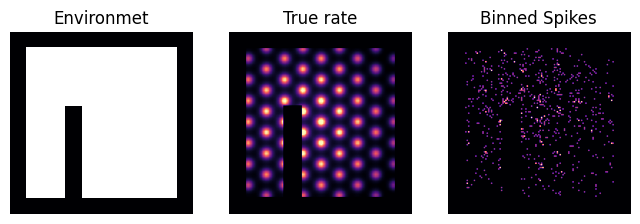

In [55]:
def pscale(x,q1=0.5,q2=99.5,domask=True):
    # Plot helper: Scale data by percentiles
    u  = x[mask] if domask else x
    p1 = percentile(u,q1)
    p2 = percentile(u,q2)
    x  = clip((x-p1)/(p2-p1),0,1)
    return x*mask if domask else x
    
def showim(x,t='',**kwargs):
    # Plot helper: Show image with title, no axes
    if len(x.shape)==1: x=x.reshape(L,L)
    imshow(pscale(x,**kwargs));
    axis('off');
    title(t);

subplot(131); showim(mask,'Environmet')
subplot(132); showim(λ0,'True rate')
subplot(133); showim(K,'Binned Spikes');

### Estimating rate in each bin

The simplest way to estimate the rate at each location is to simply divide the number of observed spikes $K$ by the number of visits $N$ to each location. This is a very noisy estimate (below, left), and is undefined when $N$ is zero. 

$$
\hat\lambda = \frac K N 
$$

It's tempting to add a little ad-hoc regularization to handle the $N=0$ case gracefully, for example $\hat\lambda = {K}/({N+\tfrac 1 2} )$. Tricks like this might seem arbitrary (and perhaps wrong), but can be more formally motivated via  Bayesian statistics. 

We assume that each time the rat visits a location with intensity $\lambda$, we observe $y$ spikes, which are Poisson distributed:

\begin{equation}
\Pr(y|\lambda) = \frac {\lambda^y e^{-\lambda}} {\Gamma(y+1)}
\end{equation}

This gives us a likelihood for estimating $\lambda$ given $y$. 
The [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) is the conjugate prior for Poisson rates, with shape parameter $\alpha$ and rate parameter $\beta$: 

\begin{equation}
\Pr(\lambda|\alpha,\beta) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} {\lambda^{\alpha-1} e^{-\beta\lambda}}.
\end{equation}

We can write the likelihood of observing a count observation $y$ given rate $\lambda$ as:

$$
\Pr(\lambda|y) \propto {\lambda^{y} e^{-\lambda}}.
$$

To combine $N$ observations $y_t\in\{y_1,..,y_T\}$, take the product of the likelihoods for each observation. This reduces to a simplified expression in terms of the total number of spikes $K=\sum_t y_t$:

\begin{equation}
\begin{aligned}
\Pr(\lambda|y_1,..,y_T)&\propto \textstyle\prod_t \lambda^{y_t} e^{-\lambda}= \lambda^K e^{-N\lambda}.
\end{aligned}
\end{equation}

To assign a rate estimate to locations with missing data, we can define a Bayesian prior for $\lambda$. This regularizes bins that have limited data, reducing variance at the expense of increased bias. For regularization strength $\rho>0$, we set $\Pr(\lambda)\sim\operatorname{Gamma}(\alpha_0,\beta_0)$, with $\beta_0=\rho$ and $\alpha_0=\rho(\mu-1)+1$, and were $\mu$ is the overall average firing rate of the neuron, regardless of location. This leads to a posterior distribution of:

\begin{equation}
\begin{aligned}
\Pr(\lambda|y_1,..,y_T) 
&\propto
\lambda^{K}e^{-N\lambda}
\cdot
[\lambda^{\alpha_0-1} e^{-\beta_0\lambda}]
\\&=
\lambda^{K+\rho(\mu-1)+1}e^{-(N+\rho)\lambda}.
\end{aligned}
\end{equation}

This gives a gamma-distributed posterior with $\alpha = K+\rho(\mu-1)+1$ and $\beta=N+\rho$. The posterior mean, $\alpha/\beta$, is a regularized estimator $\hat\lambda_\mu$ of the rate:

\begin{equation}
\hat\lambda_\mu = \frac{K+\rho(\mu-1)+1}{N+\rho}.
\end{equation}

This is biased toward higher rates due the +1 in the numerator. Using the mode $(\alpha-1)/\beta$ is another option, which lacks this bias:

\begin{equation}
\hat\lambda_\text{mode} = \frac{K+\rho\mu}{N+\rho}.
\end{equation}

One can interpolate between these mean-based and mode-based regularizers with another parameter $\gamma\in[0,1]$, where $\gamma=0$ corresponds to the mode-based estimator, and $\gamma=1$ to the mean-based estimator:

\begin{equation}
\hat\lambda = \frac{K+\rho(\mu-\gamma)+\gamma}{N+\rho}.
\end{equation}

We use $\gamma=0.5$ and $\rho=1.3$ as the default here. 

In [56]:
def regλ(N,K,ρ=1.3,γ=0.5):
    # Regularized rate estimate
    return (K+ρ*(sum(K)/sum(N)-γ)+γ)/(N+ρ)

Even with regularization, estimating the rate directly in each bin is far too noisy to be useful. Why go through all this trouble to define a principled way to regularize counts for single bins then? These regularized rate estimators provide a principled way to define how a rate estimator should behave when data are limited, and can be incorporated into better estimators that pool data from adjacent bins. Next, we explore a simple way to pool data from adjacent bins using kernel density smoothing.

In [57]:
from scipy.stats import pearsonr
def printstats(a,b,message=''):
    # Print RMSE and correlation between two rate maps
    a,b = a.reshape(L,L)[mask],b.reshape(L,L)[mask]
    NMSE = mean((a-b)**2)/sqrt(mean(a**2)*mean(b**2))
    print(message+':')
    print('∙ Normalized MSE: %0.1f%%'%(100*NMSE))
    print('∙ Pearson correlation: %0.2f'%pearsonr(a,b)[0]) 

K/N Estimator:
∙ Normalized MSE: 226.8%
∙ Pearson correlation: 0.20
Regularized Estimator:
∙ Normalized MSE: 202.1%
∙ Pearson correlation: 0.22


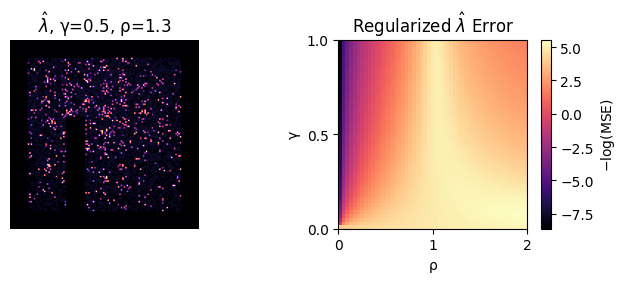

In [58]:
# Rate per bin using naive and regularized estimators
λhat1 = nan_to_num(K/N)
λhat2 = regλ(N,K)
printstats(λ0,λhat1,'K/N Estimator')
printstats(λ0,λhat2,'Regularized Estimator')

# Effect of regularization on error
ρs,γs = linspace(1e-2,2,51),linspace(0,1,51)
MAE = array([[mean(abs(λ0-regλ(N,K,ρ,γ))**2) for ρ in ρs] for γ in γs])

subplot(121); showim(λhat2,'$\hat\lambda$, γ=0.5, ρ=1.3')
subplot(122); imshow(-log(MAE),extent=(0,2,0,1),aspect=2)
xticks([0,1,2]); yticks([0,.5,1]); xlabel('ρ'); ylabel('γ');
title('Regularized $\hat\lambda$ Error')
colorbar(label='$-\log(\operatorname{MSE})$');

# Estimating rate by smoothing 

### Estimating rate via Kernel Density Estimation (KDE)

The simplest way to estimate rate is to average the spike counts over nearby regions. We'll use a Gaussian blur here. The 2D Gaussian blur is a [separable filter](https://en.wikipedia.org/wiki/Separable_filter), so we can compute it using two 1D Gaussian blurs in each direction. This can also be done quickly using the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Convolution_theorem). This amounts to [Kernel Density Estimation (KDE)](https://en.wikipedia.org/wiki/Kernel_density_estimation). 

In [59]:
def blurkernel(L,σ,normalize=False):
    # Gaussian kernel
    k = exp(-(arange(-L//2,L//2)/σ)**2)
    if normalize: 
        k /= sum(k)
    return fftshift(k)

def conv(x,K):
    # Compute circular 2D convolution using FFT
    # Kernel K should already be fourier-transformed
    return real(ifft2(fft2(x.reshape(K.shape))*K))

def blur(x,σ,**kwargs):
    # 2D Gaussian blur via fft
    kern = fft(blurkernel(x.shape[0],σ,**kwargs))
    return conv(x,outer(kern,kern))

In our case, we must also account for the nonuniform sampling of space. The rat visits some locations more than others. The solution is to smooth the spike counts $K$ and location visits $N$ separately, and then estimate the rate.

\begin{equation}
\begin{aligned}
\hat\lambda_\text{kde} &= \frac {\kappa \otimes K} {\kappa \otimes N}
\\
\kappa(\mathbf x,\mathbf x') &= \exp\left[ -\tfrac {(\mathbf x-\mathbf x')^2}{2\sigma^2}\right]
\end{aligned}
\end{equation}

In [60]:
def kdeλ(N,K,σ,**kwargs):
    # Estimate rate using Gaussian KDE
    return regλ(blur(N,σ),blur(K,σ),**kwargs)

If we want to use the regularized rate estimator defined earlier, we should normalize our smoothing kernel $\kappa(\mathbf x,\mathbf x')$ to unit height. This accounts for the fact that smoothing pools multiple observations, and so increases the certainty of our rate estimate relative to the prior.

\begin{equation}
\begin{aligned}
\hat\lambda_\text{kde} &= \frac {\kappa \otimes K+\rho(\mu-\gamma)+\gamma} {\kappa \otimes N+\rho}
\end{aligned}
\end{equation}

For analyzing the underlying grid, we might also want to remove large-scale variations in rate across the arena. We can estimate a background rate also via Gaussian smoothing, and divide out this rate to get a normalized estimate of how rate changes with location.

KDE Error:
∙ Normalized MSE: 28.5%
∙ Pearson correlation: 0.63


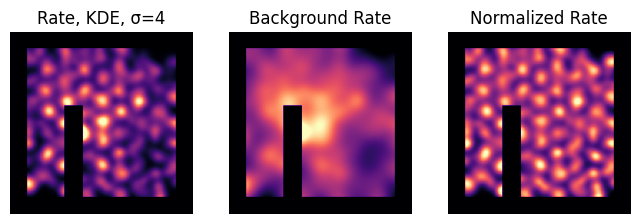

In [61]:
fgσ   = 4    # Kernel smoothing radius
bgσ   = L/15 # Background kernel radius
λhat  = kdeλ(N,K,fgσ) 
λbg   = kdeλ(N,K,bgσ)
λbar  = λhat/λbg

printstats(λ0,λhat,'KDE Error')
subplot(131); showim(λhat,'Rate, KDE, σ=%d'%fgσ);
subplot(132); showim(λbg ,'Background Rate');
subplot(133); showim(λbar,'Normalized Rate');

### Inspecting the data

Kernel density smoothing yields a good estimate of the rate map, but we need to know how much to blur the spike count data. We can also pick $\sigma$ in a principled way by examining the autocorrelation of the data. 

We can calculate the 2D autocorrelation [efficiently using the FFT](https://en.wikipedia.org/wiki/Autocorrelation#Efficient_computation). To focus on fluctuations around the mean rate, we should first subtract any constant component.

In [62]:
def zeromean(x):
    # Mean-center data, accounting for masked-out regions
    x = x.reshape(mask.shape)
    return (x-mean(x[mask]))*mask

def fft_acorr(x):
    # Zero-lag normalized to match signal variance
    x   = zeromean(x)
    # Window attenuates boundary artefacts
    win = hanning(L)
    win = outer(win,win)
    # Calculate autocorrelation using FFT
    psd = (abs(fft2(x*win))/L)**2
    acr = fftshift(real(ifft2(psd)))
    # Adjust peak for effects of mask, window
    return acr*var(x[mask])/acr[L//2,L//2]

We can collapse this 2D autocorrelation down to 1D by averaging this 2D autocorrelation as a function of radial distance. This radial autocorrelation has a large peak at zero lag, but also several smaller peaks due to the periodic tuning curve.

In [63]:
def radial_average(y):
    # Get radial autocorrelation by averaging 2D autocorrelogram
    i = int32(abs(coords)) # Radial distance
    a = array([mean(y[i==j]) for j in range(L//2+1)])
    return concatenate([a[::-1],a[1:-1]])

def radial_acorr(y):
    # Autocorrelation as a function of distance
    return radial_average(fft_acorr(y))

We can estimate the grid spacing based on the location of the first non-zero-lag peak. Here, we use sinc interpolation computed via FFT to find the location of the peak that corresponds to the grid spacing.

In [64]:
def fft_upsample_1D(x,factor=4):
    '''
    Upsample 1D array using the FFT
    '''
    n  = len(x)
    n2 = n*factor
    f  = fftshift(fft(x))*hanning(n)
    f2 = np.complex128(np.zeros(n2))
    r0 = (n2+1)//2-(n+0)//2
    f2[r0:r0+n] = f
    return np.real(ifft(fftshift(f2)))*factor

from scipy.signal import find_peaks
def acorr_peak(r,F=6):
    # sinc upsample at ×F resolution to get distance to first peak
    r2 = fft_upsample_1D(r,F)
    return min(find_peaks(r2[len(r2)//2:])[0])/F-1,r2

For grid cells, the 2D autocorrelation should show a hexagon, which reflects the three sinusoidal components that make up the periodic grid tiling (below, left).

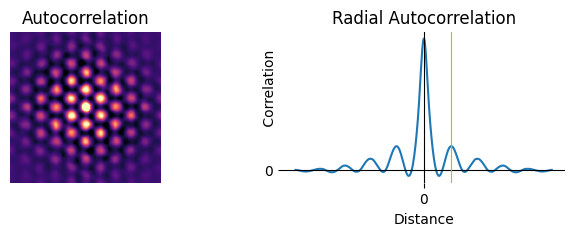

In [65]:
λhat   = kdeλ(N,K,L/75)         # Small blur for initial esitmate
acorr2 = fft_acorr(λhat)        # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 5                      # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins    

figure(figsize=(8,2))
subplot(121); showim(acorr2,'Autocorrelation',domask=False)
subplot(122); plot(linspace(-L/2,L/2,L*res)-.5/res,acup)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom','left']]
axhline(0,color='k',lw=.8); xticks([0]); xlabel('Distance'); 
axvline(0,color='k',lw=.8); yticks([0]); ylabel(' '*9+'Correlation',labelpad=-9)
axvline((0+1+P),color='y',lw=.8);
title('Radial Autocorrelation');

Once we have grid spacing $P$, we can define the scales for smoothin. We want to smooth as much as possible, but not so much that we erase the underlying grid. A Gaussian with $\sigma = P/\pi$ is a good heuristic for the largest acceptable smoothing radius. For subtracting the background, we use $\sigma_{bg} = 2.5\cdot P/\pi$.

KDE:
∙ Normalized MSE: 28.5%
∙ Pearson correlation: 0.63


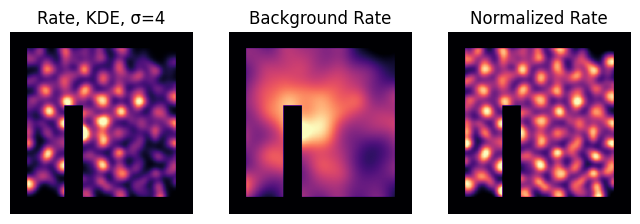

In [66]:
fgσ  = P/pi
bgσ  = fgσ*2.5
λhat = kdeλ(N,K,fgσ) 
λbg  = kdeλ(N,K,bgσ)

printstats(λ0,λhat,'KDE')
subplot(131); showim(λhat,'Rate, KDE, σ=%d'%fgσ);
subplot(132); showim(λbg ,'Background Rate');
subplot(133); showim(λbar,'Normalized Rate');

### Smoothing with Gaussian Process regression

KDE smoothing is ok, but we can do better. Gaussian Process (GP) regression provides a flexible way to handle missing data, and also lets us encode more assumptions about the spatial correlations in the underlying rate map. 

Let's start by implementing smoothing using GP regression. Recall the formula for the GP posterior mean: 

\begin{equation}
\begin{aligned}
\\
\mu
&= \left[\Sigma_0^{-1}+\Sigma_\epsilon^{-1}\right]^{-1}\left[\Sigma_\epsilon^{-1}y+\Sigma_0^{-1}\mu_0\right] 
\end{aligned}
\end{equation}

If we set the prior means to zero, this simplifies to: 

\begin{equation}
\begin{aligned}
\hat\lambda_\text{gp} = \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}\right]^{-1}\Sigma_\epsilon^{-1}y
\end{aligned}
\end{equation}

To set up our GP regression problem, we need to define the prior covariance $\Sigma_0$ and measurement precisions $\Sigma_\epsilon^{-1}$. For now, we assume uniform measurement noise of  $\sigma_\epsilon^2$ per time-point. 

We work with the binned spike counts $K$, and the total number of times the rat visits each location $N$. Binning observations lumps $N$ observations together into a single estimate. Points with more visits have less error. Bins lacking data ($N=0$) can be removed, or handled gracefully if we work with *precision* rather than variance. Precision $\tau$ is the reciprocal of variance, $\tau=1/\sigma^2$ (in the multivariate case: the inverse of the covariance matrix). For $N$ measurements with noies $\sigma_\epsilon^2$ the precision is $\tau = N/\sigma_\epsilon^2$. We therefore define the precision matrix of the observations as 

\begin{equation}
\begin{aligned}
\Sigma^{-1}_\epsilon &= \operatorname{diag}[\tau_\epsilon]
\\
\tau_\epsilon &= \frac{\operatorname{vec}[N]}{\sigma_\epsilon^2}
\end{aligned}
\end{equation}

where $\operatorname{diag}[]$ denotes constructing a diagonal matrix from a vector, and $\operatorname{vec}[]$ denotes unravelling the $L{\times}L$ array into a length $L^2$ vector.

In [67]:
# Prepare error model for GP
ε0 = mean(K)/mean(N) # variance per measurement
τe = N.ravel()/ε0    # precision per bin

We construct the prior covariance matrix $\Sigma_0$ by evaluating the kernel $\kappa(\mathbf x,\mathbf x')$ for all pairs of bins. Here, we configure the kernel heuristically: we pick an arbitrary smoothing radius, and scale the kernel height to match the estimated variance of the rate map.

In [68]:
# Build 2D kernel for the prior
# Scale kernel height to match data variance (heuristic)
k1   = blurkernel(L,fgσ*2)
y    = nan_to_num(K/N)
kern = outer(k1,k1)*var(y[mask])

from scipy.linalg import circulant 

def kernel_to_covariance(kern):
    # Covariance is a doubly block-circulant matrix
    # Use np.circulant to build blocks, then copy
    # with shift to make 2D block-circulant matrix
    assert(argmax(kern.ravel())==0)
    L = kern.shape[0]
    b = array([circulant(r) for r in kern])
    b = b.reshape(L**2,L).T
    s = array([roll(b,i*L,1) for i in range(L)])
    return s.reshape(L**2,L**2)

Here, we explore a grid size of $L=100$. For larger problems, the prior covariance might not fit in memory. As we'll see shortly, it is enough to define a routine that computes the product of the prior covariance (or its inverse) with a vector.

The numerical stability of our GP regression will be poor if our prior covariance has small eigenvalues. The eigenvalues of our covariance correspond to the coefficients of the Fourier transform of our kernel, so we can "repair" our kernel by setting too-small eivenvalues with a small positive value. 

In [69]:
def repair_small_eigenvalues(kern,mineig=1e-6):
    # Kernel must be positive; fix small eigenvalues
    assert(argmax(kern.ravel())==0)
    kfft = fft2(kern)
    keig = abs(kfft)
    υmin = mineig*np.max(keig)
    zero = keig<υmin
    kfft[zero] = υmin
    kern = real(ifft2(maximum(υmin,kfft)))
    return kern

To solve our GP regression problem, we use the following form for the posterior mean. This form avoids inverting the prior covariance, so it's more numerically stable. 

\begin{equation}
\begin{aligned}
\mu
&=
\left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}\right]^{-1} \Sigma_\epsilon^{-1} y
\\&=
\left[\Sigma_0^{-1} + \operatorname{diag}[\tau_\epsilon]\right]^{-1} \operatorname{diag}[\tau_\epsilon] y
\\&=
\left[\Sigma_0 \operatorname{diag}[\tau_\epsilon] + I\right]^{-1} \Sigma_0 \operatorname{diag}[\tau_\epsilon]y
\end{aligned}
\end{equation}

We apply a few optimizations for speed.

- $\operatorname{diag}[\tau_\epsilon]y$ can be evaluated as $\operatorname{diag}[\tau_\epsilon\circ y]$, where $\circ$ is element-wise multiplication.
- $\Sigma_0 \operatorname{diag}[\tau_\epsilon]$ can be evaluated with row-wise multiplication $\Sigma_0 \circ (\tau_\epsilon{\tt1}^\top)$.
- $\Sigma_0\mathbf u$ can be evaluated via convolution using the FFT.

Finally, we use `scipy.sparse.minres` to solve the linear system 

\begin{equation}
\begin{aligned}
\mu &= A^{-1}\mathbf v
\\
A&=\Sigma_0 \operatorname{diag}[\tau_\epsilon] + I
\\
\mathbf v&=\Sigma_0^{-1} \operatorname{diag}[\tau_\epsilon]y
.
\end{aligned}
\end{equation}

Minres stands for "minimum residual", and is a type of Krylov subspace solver. It works by re-phrasing $\mu = A^{-1}\mathbf v$ as:

\begin{equation}
\mu = \underset{\mu}{\operatorname{argmin}} \| A\mu - \mathbf v\|^2
\end{equation}

And then minimizing this error ("residual"). We do not need to explicitly construct $A$ (which is memory intensive), but instead supply a function that calculates $A\mu$ for any given vector $\mu$. This can be evaluated efficiently as element-wise multiplications and convolutions implemented via FFT.

In [70]:
import time
ttic = None
def tic(msg=''):
    # Timer routine to track performance
    global ttic
    t = time.time()*1000
    if ttic and msg: 
        print(('Δt = %d ms'%(t-ttic)).ljust(14)\
              +'elapsed for '+msg)
    ttic = t
    
def showkn(k,t):
    # Plot helper; Shift convolution kernel to plot
    imshow(fftshift(k)); axis('off'); title(t);

In [71]:
from scipy.sparse.linalg import minres,LinearOperator

def solveGP(kern,y,τe,tol=1e-4,reg=1e-5):
    # Minimum residual solver is fast
    kern = repair_small_eigenvalues(kern,reg)
    knft = fft2(kern)
    τy   = τe*zeromean(y).ravel()
    Στy  = conv(τy,knft).ravel()
    Hv   = lambda v:conv(τe*v,knft).ravel() + v
    ΣτεI = LinearOperator((L**2,L**2),Hv,Hv,dtype=np.float64)
    μ    = minres(ΣτεI,Στy,tol=tol)[0]
    return μ.reshape(L,L) + mean(y[mask])

GP regression error:
∙ Normalized MSE: 23.8%
∙ Pearson correlation: 0.70


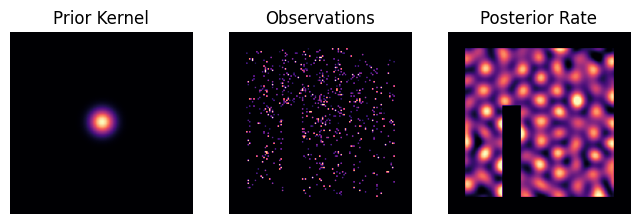

In [72]:
λGP1 = solveGP(kern,y,τe.ravel())
printstats(λ0,λGP1,'GP regression error')
subplot(131); showkn(kern,'Prior Kernel');
subplot(132); showim(y,'Observations');
subplot(133); showim(λGP1/λbg,'Posterior Rate');

# Sometimes GP regression reduces to convolution

It seems like GP regression yields similar results to kernel density estimation. Can we relate these two operations? Recall the solution for the GP posterior:

\begin{equation}
\begin{aligned}
\mu = \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}\right]^{-1}\Sigma_\epsilon^{-1}y.
\end{aligned}
\end{equation}

The prior $\Sigma_0$ is a positive semi-definite matrix, so it can be written in terms of the eigenvalue decomposition

\begin{equation}
\Sigma_0 = \text F \operatorname{diag}[\tilde k] \text F^{-1},
\end{equation}

where $\tilde k$ is a vector of eigenvalues and $\operatorname F$ is a unitary basis. If $\Sigma_\epsilon^{-1}$ can also be diagonalized by $\operatorname F$ as $\Sigma_\epsilon^{-1} = \operatorname F \operatorname{diag}[\tilde\tau] \operatorname F^\top$, then the posterior mean simplifies to 

\begin{equation}
\begin{aligned}
\mu = \operatorname F \operatorname{diag}\left[\tfrac {\tilde k \tilde \tau} {\tilde k \tilde \tau + 1}\right] \operatorname F^{-1} y.
\end{aligned}
\end{equation}

In the special case that all measurements have noise $\sigma_\epsilon^2$, the precision matrix $\Sigma_\epsilon^{-1} = I/\sigma_\epsilon^2$ is proportional to the identity, and the GP posterior reduces to:

\begin{equation}
\begin{aligned}
\mu = \text F \operatorname{diag}\left[\tfrac {\tilde k} {\tilde k + \sigma_\epsilon^2}\right] \text F^{-1} y.
\end{aligned}
\end{equation}

When the GP is evaluated on a regularly-spaced grid, the eigenspace $\text F$ is Fourier space, and $\text F$ is the (unitary) Fourier transform. The above matrix operations can therefore be computed as a convolution ($\otimes$) with the kernel $g(\mathbf x,\mathbf x')$:

\begin{equation}
\begin{aligned}
g(\mathbf x,\mathbf x') &= \text F^{-1} \operatorname{diag}\left[\tfrac {\tilde k} {{\tilde k} + \sigma_\epsilon^2}\right]
\\
\mu&\approx g \otimes y.
\end{aligned}
\end{equation}

For large measurement error $\sigma_\epsilon^2\gg\tilde k$, the kernel $g(\mathbf x,\mathbf x')$ is approximately proportional to the prior kernel $\kappa$. When the measurement error is small $\sigma_\epsilon^2\ll\tilde k$, convolution with $g(\mathbf x,\mathbf x')$ approximates the identity transformation. 

This highlights that sometimes filtering the observations with a convolution kernel gives you something almost as good as a GP regression. This is much simpler, and is often good enough.

In [73]:
def mirrorpad(y,pad):
    # Reflected boundary for convolution
    y[:pad, :]=flipud(y[ pad: pad*2,:])
    y[:, :pad]=fliplr(y[:, pad: pad*2])
    y[-pad:,:]=flipud(y[-pad*2:-pad,:])
    y[:,-pad:]=fliplr(y[:,-pad*2:-pad])
    return y

Error between GP regression and convolution:
∙ Normalized MSE: 18.9%
∙ Pearson correlation: 0.90


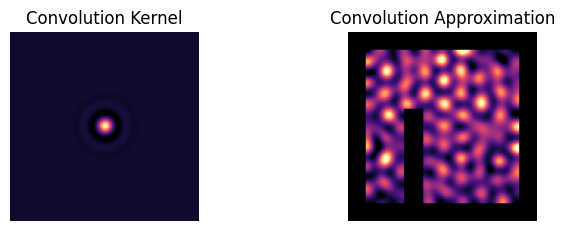

In [74]:
# Uniform measurement error ⇒ GP = convolution
μτ   = mean((N/ε0)[mask])
kft  = fft2(kern)
gft  = (kft*μτ)/(kft*μτ+1)
y    = mirrorpad(nan_to_num(K/N),pad)
μy   = mean(y[mask])
λcnv = conv(y-μy,gft)+μy

printstats(λcnv,λGP1,'Error between GP regression and convolution')
subplot(121); showkn(real(ifft2(gft)),'Convolution Kernel');
subplot(122); showim(λcnv/λbg,'Convolution Approximation');

# Better priors

So far, we've only used GP regression with a Gaussian prior. When analyzing data from grid cells, the real power of GP regression lies in being able to encode the knowledge that the grid should be periodic into the GP prior kernel. 

To construct a periodic prior, we estimate the autocorrelation from a perfect grid. To avoid assuming any particular orientation, we make the kernel radially symmetric. To avoid inferring long-range interactions where none exist, we taper the kernel to look only at the local neighborhood.

In [75]:
from scipy.interpolate import interp1d
def radial_kernel(rk):
    # Make radially symmetric 2D kernel from 1D radial kernel
    r    = abs(coords)
    kern = interp1d(arange(L//2),rk[L//2:],
                    fill_value=0,bounds_error=0)(r)
    return fftshift(kern)

# Make symmetric kernel from autocorrelation of ideal grid
acgrd = fft_acorr(ideal_hex_grid(L,P))
kernR = radial_kernel(radial_average(acgrd))

# Restrict kernel to local neighborhood and normalize
window   = abs(coords)<P*sqrt(2)
kern0    = blur(kernR*fftshift(window),P/pi)
kern0    = kern0/np.max(kern0)

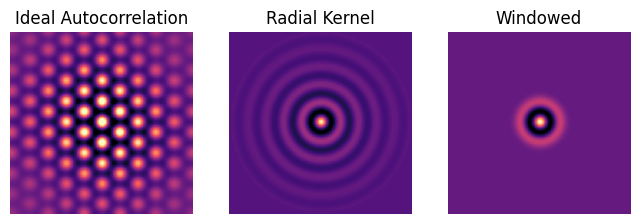

In [76]:
subplot(131); showim(acgrd,'Ideal Autocorrelation',domask=False);
subplot(132); showkn(kernR,'Radial Kernel');
subplot(133); showkn(kern0,'Windowed');

We adapt the kernel to the observed statistics of the spike count data by scaling the zero-lag peak in the kernel to match a estimate of the variance in the rate. 

The zero-lag autocorrelation of the data reflects the sum of the true variance in the underlying rates, plus the average measurement noise. 

To remove the contribution from the measurement noise, we estimating the zero-lag variance by fitting a quadratic polynomial to the correlation at nearby, nonzero lags.

This prior encodes the assumption that the observed spike counts have a periodic underlying structure, and leads to better recovery of the grid fields.

In [77]:
def zerolag(ac,r=3):
    # Estimate true zero-lag variance via quadratic interpolation.
    z = array(ac[L//2-r:L//2+r+1])
    v = arange(r*2+1)
    return polyfit(v[v!=r],z[v!=r],2)@[r**2,r,1]

# Estimate zero-lag variance and scale kernel
acorrR1 = radial_acorr(regλ(N,K))
acorrR2 = copy(acorrR1)
v0      = zerolag(acorrR1)
kern    = kern0*v0
acorrR2[L//2] = v0

GP with periodic kernel:
∙ Normalized MSE: 28.1%
∙ Pearson correlation: 0.82


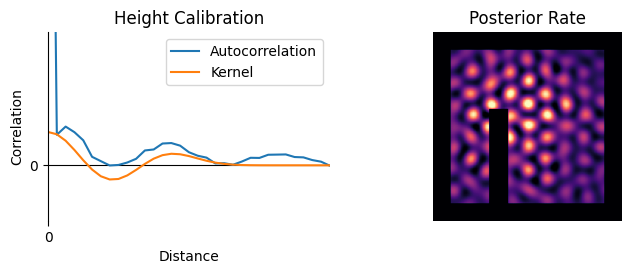

In [78]:
ε0   = mean((K/N)[N>0])
λGP2 = solveGP(kern,y,N.ravel()/ε0)
printstats(λ0,λGP2,'GP with periodic kernel')

subplot(121)
axhline(0,color='k',lw=.8)
plot(acorrR1[L//2:],label='Autocorrelation')
plot(kern[0,:L//2] ,label='Kernel')
xticks([0]); xlabel('Distance');    xlim(0,L//4)
yticks([0]); ylabel('Correlation'); ylim(ylim()[0],v0*4)
[gca().spines[s].set_visible(0) for s in ['top','right','bottom']];
legend(); title('Height Calibration')
subplot(122); showim(λGP2,t='Posterior Rate');

# Heuristic approximation of Poisson noise

Neuronal spiking is typically treated as conditionally Poisson, which means its variance should be proportional to the firing rate. Let's explore a heuristic way to incorporate a Poisson noise assumption into our GP regressions. Earlier, we discussed how the gamma distribution could serve a conjugate prior for Poisson count data. We can also use a Gamma distribution to model the measurement uncertainty from a collection of Poisson observations, and incorporate this model of uncertainty into our GP regression.

The variance of a $\operatorname{Gamma}(\alpha,\beta)$ distribution is $\sigma^2=\alpha/\beta^2$. The regularized rate estimator given $K$ spikes in $N$ visits to a given location yields a Gamma distribution with with $\alpha = K+\rho(\mu-\gamma)+1$ and $\beta=N+\rho$. The variance, then, is

\begin{equation}
\sigma^2_\epsilon=\tfrac{\alpha}{\beta^2}=\tfrac{K+\rho(\mu-\gamma)+1}{(N+\rho)^2}
\end{equation}

Performance for this model of the error is mixed: it can work better than assuming constant error when data are limited, but sometimes performs worse than simply assuming uniform variance equal to the neuron's average firing rate. We discuss a more principled way to handle Poisson noise in the next section. 

GP:
∙ Normalized MSE: 48.4%
∙ Pearson correlation: 0.75


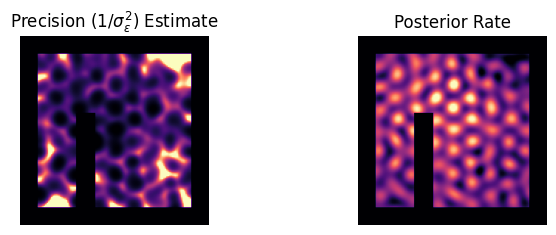

In [79]:
# Use estimated rate as measurement error variance
ve = kdeλ(N,K,fgσ,ρ=1,γ=.5)
y  = nan_to_num(K/N)
λGP3 = solveGP(kern,y,(N/ve).ravel())
printstats(λ0,λGP3,'GP')
subplot(121); showim(1/ve,q2=95,t='Precision ($1/\sigma^2_\epsilon$) Estimate');
subplot(122); showim(λGP3,'Posterior Rate');

# Log-Gaussian Cox Processes

So far, we've been using GP regression to estimate the underlying rate. This works, but entails some heuristic decisions about how to model measurement noise. Can we do better? 

We can get an even better model of the data by fitting a log-Gaussian [Cox process](https://en.wikipedia.org/wiki/Point_process#Cox_point_process) model to the binned count observations. This places a Gaussian process prior on the logarithm of the intensity, $\ln(\lambda)$, and assumed that spike count observations are conditionally Poisson: 

\begin{equation}
\begin{aligned}
y&\sim\operatorname{Poisson}(\lambda)
\\
\lambda &= \exp(\mathbf w^\top \mathbf x)
\\
\mathbf w&\sim \mathcal N(0,\Sigma_0)
\end{aligned}
\end{equation}

Above, $\mathbf w$ are the log-rates that we want to infer, and $\mathbf x$ is a an indicator vector which is 1 for the rat's current binned location and zero otherwise.

Recall that the probability of observing spike count $y$ given rate $\lambda$, for Poisson-distributed spike counts, is:

\begin{equation}
\Pr(y|\lambda) = \frac {\lambda^y e^{-\lambda}} {\Gamma(y+1)}
\end{equation}

We work with log-probability for numerical stability. The log-probability of observing spike count $y$ given rate $\lambda$, for Poisson-distributed spike counts, is:

\begin{equation}
\ln\Pr(y|\lambda) = y \ln \lambda -\lambda + \text{const.}
\end{equation}

We estimate a posterior distribution on $\mathbf w$ by multiplying our Gaussian process prior by this Poisson likelihood, for all $T$ time points. 

### The maximum a posteriori estimate

We find $\mathbf w$ that maximizes the posterior probability of the observed spike counts. This is the [Maximum A Posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimator. For this, we need only calculate the posterior log-probability up to a constant. By convention, we work with the negative log-posterior so that finding the MAP is a minimization problem. 

The negative log-posterior $\mathcal L=-\ln\Pr(Y|x,\mathbf w,\beta)$, summed over all observations $\text Y=\{y_1,..,y_T\}$, $\text X=\{\mathbf x_1,..,\mathbf x_T\}$, is:

\begin{equation}
\begin{aligned}
\mathcal L &= 
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w 
- \textstyle\sum_{t=1}^T [y_t \ln(\lambda_t) - \lambda_t] 
+ \text{const.}
\\
\lambda_t &= \exp(\mathbf w^\top \mathbf x_t)
\end{aligned}
\end{equation}

We bin the data into $r\in{1..R}$ spatial regions. Each site $r$ has $n_r$ visits in which we observe $k_r$ spikes. Define $\bar y_r=k_r/n_r$ as the empirical rate in each region. We can rewrite the sum over all timepoints in the log likelihood, as a sum over all spatial regions: 

\begin{equation}
\begin{aligned}
\textstyle\sum_{t=1}^T y_t \ln(\lambda_t) - \lambda_t &=
\textstyle\sum_{r=1}^R n_r [ \bar y_r \ln(\lambda_r) - \lambda_r ]
\end{aligned}
\end{equation}

The negative log-posterior can then be written as:

\begin{equation}
\begin{aligned}
\mathcal L =
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w
+\textstyle\sum_{r=1}^R n_r [\lambda_r  - \bar y_r \ln(\lambda_r)]
+\text{const.}
\end{aligned}
\end{equation}

Written as a sum over bins like this, $\lambda_r = \exp(\mathbf w^\top \mathbf x_r) = \exp(\mathbf w_r)$ the log-posterior simplifies to:

\begin{equation}
\begin{aligned}
\mathcal L =
\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w
+\textstyle\sum_{r=1}^R n_r [\exp(\mathbf w_r)  - \bar y_r \mathbf w_r]
+\text{const.}
\end{aligned}
\end{equation}

We find the MAP by minimizing the above as a function of $\mathbf w$. This can be solved via gradient descent. 
However, I found that most of the optimization routines in Scipy's `minimize` function performed poorly, either crashing, failing to terminate. Scipy's conjugate gradient method performed the best, but achieved poor error tolerance. Instead, we can build our own Newton-Raphson solver. 

### Finding the maximum a posteriori using Newton-Raphson

Newton-Raphson solves a linear system on each iteration. Each iteration takes the same amount of time as solving a single GP regression problems. 

*(Indeed, one can view each stage of Newton-Raphson as its own GP regression problem. This is the idea behind the [Iteratively Reweighted Least Squares](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares) (IRLS) approach to fitting Generalized Linear Models (GLMs). The Gaussian process model used here can be viewed as a Poisson GLM with the GP prior acting as a regularizer. [Lieven Clement](https://statomics.github.io/SGA2019/assets/poissonIRWLS-implemented.html) has a good introduction on IRLS.)*

Each iteration of Newton-Raphson updates the parameters as

\begin{equation}
\mathbf w_{i+1} = \mathbf w_i - \mathbf H^{-1} \mathbf J,
\end{equation}

where $\mathbf J = \nabla\mathcal L$ and $\mathbf H = \nabla\nabla^\top\mathcal L$ are the Jacobian (gradient)  and Hessian (curvature) of our negative log-posterior at the current parameter estimate $\mathbf w_i$.

To apply Newton-Raphson we need to calculate the Hessian matrix and Jacobian vector. We can express these as a sum of a contribution from the log-prior and log-likelihood. 

The negative log-prior is $\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w$ (up to a constant). We can express its contribution to the Hessian and Jacobian in terms of vector derivatives in $\mathbf w$:

\begin{equation}
\begin{aligned}
\mathbf J_0 &=
\nabla_\mathbf w [\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w]
\\&=
\tfrac 1 2 [\mathbf w^\top \Sigma_0^{-1} +  \Sigma_0^{-1} \mathbf w]
\\&= 
\Sigma_0^{-1} \mathbf w
\\
\mathbf H_0 &=
\nabla\nabla^\top_\mathbf w [\tfrac 1 2 \mathbf w^\top \Sigma_0^{-1} \mathbf w] 
\\&= \Sigma_0^{-1}
\end{aligned}
\end{equation}

For the negative log-likelihood $\ell=\textstyle\sum_{r=1}^R n_r[\exp(\mathbf w_r)-\bar y_r\mathbf w_r]$, only the rate $\lambda_r$ contributes to the corresponding derivatives in $w_r$:

\begin{equation}
\begin{aligned}
\partial_{w_r}\ell 
&= n_r [\exp(\mathbf w_r)-\bar y_r]
= n_r [\lambda_r-\bar y_r]
\\
\partial^2_{w_r} \ell 
&= n_r \exp(\mathbf w_r)
= n_r \lambda_r.
\end{aligned}
\end{equation}

These can be written in vector form as

\begin{equation}
\begin{aligned}
\mathbf J_\ell& = N\circ(\lambda-\bar y)
\\
\mathbf H_\ell&=\operatorname{diag}[N\circ\lambda],
\end{aligned}
\end{equation}

where $\circ$ denotes element-wise multiplication and $N=\{n_1,..,n_R\}$, $\lambda=\{\lambda_1,..,\lambda_R\}$, and $\lambda=\{\bar y_1,..,\bar y_R\}$, are column vectors of the number of visits per bin, the current estimated rates, and the empirical rates, respectively. 

The Jacobian and Hessian can be written as: 
    
\begin{equation}
\begin{aligned}
\mathbf J &= 
\mathbf J_0+\mathbf J_\ell=
\Sigma_0^{-1}\mathbf w+N\circ(\lambda-\bar y)
\\
\mathbf H&=
\mathbf H_0+\mathbf H_\ell=
\Sigma_0^{-1}+\operatorname{diag}[N\circ\lambda]
\end{aligned}
\end{equation}

The Newton-Raphson update is then given by

\begin{equation}
\begin{aligned}
\mathbf w_{n+1}
&=
\mathbf w_{n}
-\mathbf H^{-1} \mathbf J
\\&=
\mathbf w_{n}
-
\left[
\Sigma_0^{-1}+\operatorname{diag}[N\circ\lambda]
\right]
^{-1}
\left[
\Sigma_0^{-1}\mathbf w_{n}+
N\circ(\lambda-\bar y)
\right]
\end{aligned}
\label{eq:lgcpnr1}
\end{equation}

#### Note: (pre) conditioning

As in GP regression, this problem can be numerically unstable if $\Sigma_0$ has smal eigenvalues. One can mitigate this by multiplying both the Hessian and Jacobain on the left by $\Sigma_0$ (i.e. [preconditioning](https://en.wikipedia.org/wiki/Preconditioner#Preconditioning_for_linear_systems)).

\begin{equation}
\begin{aligned}
\mathbf w_{n+1}
&=
\mathbf w_{n}
-
\left[
\Sigma_0\operatorname{diag}[N\circ\lambda] + I
\right]
^{-1}
\left\{
\mathbf w_{n}+\Sigma_0 [N\circ(\lambda-\bar y)]
\right\}
\end{aligned}
\end{equation}

However, when $\Sigma_0$ is invertable, it is faster in practice to use form $\eqref{eq:lgcpnr1}$, and pass an operator that computes $f(\mathbf v)=\Sigma_0\mathbf v$ to the preconditioner argument of `minres`. 

#### Note: when to use a separate bias term?

Sometimes, you might want to separate out the average log-rate, and paramterize the LGCP as $\Theta=(\mathbf w,\beta)$; $\lambda=\exp(\mathbf w+\beta)$. Why? We want to avoid placing prior assumptions on the average firing rate of the neuron. The average rate therefore corresponds to a direction in our Gaussian process that is entirely unconstrained, i.e. has infinite variance in the prior. 

Since GP regression is linear, the average firing rate is the maximum likelihood estimate of the average of the posterior mean, and it suffices to subtract the average rate before inferring the firing rate map. The average log-rate is less straightforward to estimate in LGCP regression, and it must be inferred along with the weights during optimization.

Here, we limit small eigenvalues of $\Sigma_0$, so that $\Sigma_0^{-1}$ is well-defined. We then zero-out the uniform (average) rate component of $\Sigma_0^{-1}$ by setting the DC term in its Fourier transform to zero.

However, in other applications $\Sigma_0$ might be sufficiently low-rank that computing even a regularized $\Sigma_0^{-1}$ is impractical or inaccurate. In this case, one can avoid inverting $\Sigma_0$ by treating the unconstrained mean as an additional bias parameter $\beta$ that is unaffected by the prior. 

#### Note: Iteratevely Reweighted Least-Squares (IRLS)

The Iteratevely Reweighted Least-Squares (IRLS) approach recasts the Newton-Raphson iteration as solving a new GP regression problem. Rewrite the Newton-Raphson iteration as:

\begin{equation}
\begin{aligned}
\mathbf w_{n+1}
&=\mathbf w_{n}-\mathbf H^{-1}\left[\Sigma_0^{-1}\mathbf w_{n}+N\circ(\lambda-\bar y)\right]
\\&=\mathbf H^{-1}\left[\mathbf H\mathbf w_{n}-\Sigma_0^{-1}\mathbf w_{n}+
N\circ(\lambda-\bar y)
\right]
\\&=\mathbf H^{-1}\left[\left(\Sigma_0^{-1}+\operatorname{diag}[N\circ\lambda]\right)\mathbf w_{n}-\Sigma_0^{-1}\mathbf w_{n}+N\circ(\lambda-\bar y)\right]
\\&=\mathbf H^{-1}\operatorname{diag}[N\circ\lambda]\left[\mathbf w_{n}+(1-\bar y/\lambda)\right]
\end{aligned}
\end{equation}

Recall the formula for the GP posterior is  $\mu= \Sigma \left[\Sigma_0^{-1}\mu_0 + \Sigma_\epsilon^{-1}y \right]$ and $\Sigma = \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}$. Matching terms, we get:

\begin{equation}
\begin{aligned}
\Sigma_0^{-1} &= \Sigma_0^{-1}
\\
\mu_0 &= 0
\\
\Sigma_\epsilon^{-1} &= \operatorname{diag}[N\circ\lambda]
\\
y &= \mathbf w_n + 1-\bar y/\lambda
\end{aligned}
\end{equation}

This confirms that estimating the LGCP posterior has similar complexity to GP regression.

#### Note: initializing a prior for log-Gaussian inference

So far, we have defined a Poisson observation model and log-posterior loss function for a log-Gaussian point-process model of the grid cell. We also need to initialize a sensible prior for the weights $\mathbf w$, which will correspond to our estimates of $\ln\lambda$. We'll use the same periodic kernel from earlier, but normalize the kernel height to the variance of the log-rate, estimated via KDE. 

#### Note: Hessian-vector products

We can gain the benefit of Krylov subspace methods in LGCP regression by defining a routine to compute the product of the Hessian and a vector. 

\begin{equation}
\begin{aligned}
\mathbf H \mathbf v
&= 
\Sigma_0^{-1}\mathbf v+\operatorname{diag}[\nu]\mathbf v
\\
&= 
\text F^{-1} \left[\tfrac 1 {\tilde\kappa} \circ\text F\,\mathbf v\right]
+\nu\circ\mathbf v
\end{aligned}
\end{equation}

In [80]:
# define a "safe log" function
minrate = 1e-2
slog = lambda x:log(maximum(minrate,x))

In [81]:
# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()
y    = nan_to_num(K/N)
lλh  = slog(kdeλ(N,K,fgσ))
kern = kern0*zerolag(radial_acorr(lλh))
kern = repair_small_eigenvalues(kern,1e-5)
knft = fft2(kern)
kift = 1/knft
kift[0,0]=0

# preconditioner given by prior covariance
Mv = lambda v:conv(v,knft).ravel()
M  = LinearOperator((L**2,)*2,Mv,Mv,dtype=np.float32)

def jacobian(w):
    J0 = conv(w,kift).ravel()
    Jl = n*(exp(w)-y.ravel())
    return J0+Jl

def hessian(w):
    # Hessian as linear operator to use with minres
    nλ = n*exp(w)
    Hv = lambda u:conv(u,kift).ravel()+u*nλ
    return LinearOperator((L**2,)*2,Hv,Hv,dtype=np.float64)

LGCP, log-rate:
∙ Normalized MSE: 1.8%
∙ Pearson correlation: 0.79


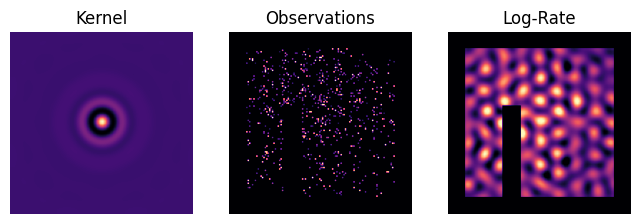

In [82]:
def newton_raphson(lλh,J,H,tol=1e-3,mtol=1e-5):
    u = lλh.ravel()
    for i in range(10):
        Δ = -minres(H(u),J(u),tol=mtol,M=M)[0]
        u += Δ
        if max(abs(Δ))<tol: return u
    print('Iteration did not converge')

w1    = newton_raphson(lλh,jacobian,hessian)
LGCP1 = w1.reshape(L,L)
printstats(slog(λ0), LGCP1,'LGCP, log-rate')
subplot(131); showkn(kern ,'Kernel');
subplot(132); showim(y    ,'Observations');
subplot(133); showim(LGCP1,'Log-Rate');

### Subtracting the background

We can modify our log-Gaussian cox process model to subtract background rate by adding the estimated background log-rate as an offset during inference. 

In [83]:
λhat = kdeλ(N,K,fgσ) # Foreground rate
λbg  = kdeλ(N,K,bgσ) # Background rate
lλh  = slog(λhat)    # Log rate
lλb  = slog(λbg)     # Log background

# Precompute variables; Passed as globals to jac/hess
kern = kern0*zerolag(radial_acorr(lλh-lλb))
kern = repair_small_eigenvalues(kern,1e-5)
knft = fft2(kern)
kift = 1.0/knft
Mv   = lambda v:conv(v,knft).ravel()
M    = LinearOperator((L**2,)*2,Mv,Mv,dtype=np.float32)

def jacobian(w):
    J0 = conv(w,kift).ravel()
    Jl = n*(exp(w+lλb.ravel())-y.ravel())
    return J0+Jl

def hessian(w):
    nλ = n*exp(w+lλb.ravel())
    Hv = lambda u:conv(u,kift).ravel()+u*nλ
    return LinearOperator((L**2,)*2,Hv,Hv,dtype=np.float64)

LGCP, log-rate:
∙ Normalized MSE: 2.2%
∙ Pearson correlation: 0.76


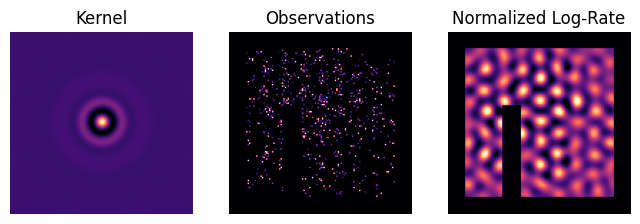

In [84]:
# Fit model and unpack result
w2    = newton_raphson(lλh-lλb,jacobian,hessian)
LGCP2 = w2.reshape(L,L) + lλb
printstats(slog(λ0),LGCP2,'LGCP, log-rate')
subplot(131); showkn(kern,'Kernel');
subplot(132); showim(y,'Observations');
subplot(133); showim(w2,'Normalized Log-Rate');

# Convolution approximation

We can also approximate the log-Gaussian model as a convolution. This amounts to considering only the first iteration of Newton-Raphson as if it were a GP regression problem, and replacing the per-bin measurement noise with its average. Consider a single iteration of the Newton-Raphson iteration, for the weights alone. This is: 

\begin{equation}
\begin{aligned}
\mathbf w_{i+1} 
&= 
\mathbf w_{i} - [\Sigma_0^{-1} + \Sigma_\varepsilon^{-1}]^{-1} \left[
\Sigma_0^{-1} \mathbf w_{i} 
+ 
N\circ(\lambda - \bar y)
\right],
\end{aligned}
\end{equation}

where $\Sigma_\varepsilon = \operatorname{diag}[N\circ\lambda]^{-1}$. Now, approximate $\Sigma_\varepsilon\approx\sigma^2_\epsilon I$ where $\sigma^2_\epsilon=\langle(N\circ\lambda)^{-1}\rangle$:

\begin{equation}
\begin{aligned}
\hat {\mathbf w} 
&\approx 
\mathbf w_0
 - [\Sigma_0^{-1} + \tfrac 1 {\sigma^2_\epsilon} I]^{-1} \left[
\Sigma_0^{-1} \mathbf w_{i} 
+ 
N\circ(\lambda-\bar y)
\right]
\\
&=
\mathbf w_0 
- \text F \tfrac {\sigma^2_\epsilon} {\tilde k+\sigma^2_\epsilon} \text F^{-1} 
\mathbf w_0 
- \text F \tfrac {\sigma^2_\epsilon \tilde k} {\tilde k+\sigma^2_\epsilon} \text F^{-1} 
N\circ(\lambda-\bar y)
\end{aligned}
\end{equation}

This implies an approximate solution in terms of two convolutions:

\begin{equation}
\begin{aligned}
\hat {\mathbf w} 
\approx 
\mathbf w_0 
&- g\otimes\{\mathbf w_0 + \kappa\otimes[N\circ(\lambda-\bar y)]\}
\\
g(\mathbf x,\mathbf x') &= \text F^{-1} \left[ \tfrac {\sigma^2_\epsilon} {\tilde k+\sigma^2_\epsilon}, \right]
\end{aligned}
\end{equation}

where $\kappa(\mathbf x,\mathbf x')$ is the GP prior and $\tilde k$ is its Fourier transform. This can be calculated almost instantaneously, and differs from the MAP in this example by only a few percent.

In [85]:
def LGCP_convolutional(N,K,fgσ,bgσ,kern,pad):
    # Evaluate via convolution
    kern = repair_small_eigenvalues(kern)
    y  = mirrorpad(nan_to_num(K/N),pad)
    λ  = kdeλ(N,K,fgσ) 
    lb = slog(kdeλ(N,K,bgσ))
    w  = slog(λ)-lb
    β  = mean(w[N>0])
    w  = w-β
    c  = mean(1/(N*λ)[N>0])
    Σf = fft2(kern)
    Gf = c/(c+Σf)
    w -= conv(w+conv(N*(λ-y),Σf),Gf)
    return w+β+lb

Error between Newton-Raphson and convolution:
∙ Normalized MSE: 0.7%
∙ Pearson correlation: 0.96


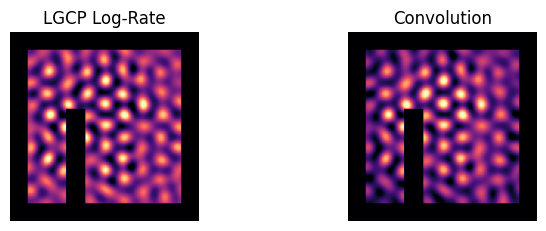

In [86]:
LGCP3 = LGCP_convolutional(N,K,fgσ,bgσ,kern,pad)
printstats(LGCP2,LGCP3,'Error between Newton-Raphson and convolution')

subplot(121); showim(LGCP2-lλb,'LGCP Log-Rate')
subplot(122); showim(LGCP3-lλb,'Convolution');

# Interim summary

 - **Introduction:**
   - Reviewed Bayesian inference for Gaussian processes 
   - Simulated spiking observations from a hippocampal grid cell
   - Discussed estimators of spike rate
   

 - **Smoothing approaches:**
   - Inferred grid rate maps using KDE
   - Illustrated smoothing using GP regression
   - Showed that GP smoothing is similar to KDE
   - Developed a periodic kernel for inferring grid maps with GP regression

 - **Log-Gaussian Cox processes (LGCP)**
   - Introduced log-Gaussian Cox Processes for inferring rate mapss
   - Derived the Jacobian and Hessian for the log-posterior of the LGCP
   - Solved for the MAP estimator of the LGCP using Newton-Raphson
   - Illustrated that the LGCP MAP estimate can be approximated via convolution
   - Shown how to subtract background rate variations in the LGCP model
 
Almost done!

# Estimating confidence intervals around peaks

One question that might be nagging you at this point is: should we believe the inferred rate maps? When we see a peak (a "grid field"), ***is this real***, or just a noisy fluctuation? For this, it is useful generate some sort of confidence bounds or other summary of uncertainty in the inferred grid map. 

First, let's find our peaks

In [87]:
def findpeaks(q,th=-inf,r=1):
    # Local maxima > th in square neighborhood radius r. 
    L  = q.shape[0]
    D  = 2*r
    Δ  = range(D+1)
    q0 = q[r:-r,r:-r,...]
    p  = q0>th
    for i,j in {(i,j) for i in Δ for j in Δ if i!=r or j!=r}:
        p &= q0>=q[i:L+i-D,j:L+j-D,...]
    p2 = zeros(q.shape,bool)
    p2[r:-r,r:-r,...] = p
    return p2

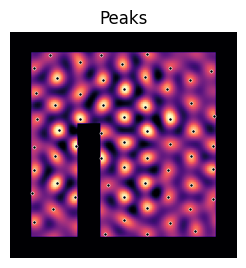

In [88]:
pxy = array(where((findpeaks(LGCP2)*mask).T))
figure(figsize=(4,3));
showim(w2,'Peaks'); 
scatter(*pxy,s=5,facecolor='k',edgecolor='w',lw=0.4);

Both GP regression and LGCP model provide estimates of the posterior covariance, which encodes the uncertainty in our posterior mean (or mode). 

For GP regression, the covariance is

\begin{equation}
\begin{aligned}
\Sigma_\text{post}
&= \left[\Sigma_0^{-1} + \Sigma_\epsilon^{-1}  \right]^{-1}
\end{aligned}
\end{equation}

For the LGCP model, we can use the Laplace approximation to model the uncertainty in our MAP estimate $\hat{\mathbf w}$. This models the posterior covariance as the inverse of the Hessian, evaluated at $\hat{\mathbf w}$. 

Intuitively, directions with higher curvature in our loss function are more constrained, and so have lower posterior variance. Conversely, unconstrained directions have low curvature, and therefore large posterior variance. 

\begin{equation}
\begin{aligned}
\Sigma_\text{post}
&= \mathbf H_{\mathbf w}^{-1}
= \left[\Sigma_0^{-1}+\operatorname{diag}[N\circ\hat\lambda]\right]^{-1}
\end{aligned}
\end{equation}

Incidentally, the curvature of the observation likelihood in the LGCP model, $\operatorname{diag}[N\circ\hat\lambda]$, is equivalent to the measurement precision $\Sigma_\epsilon^{-1}$ in GP regression. This highlights that what the LGCP model is simply finding $\hat\lambda$ such that the observed measurement errors are consistent with a Poisson error model, $\sigma_\varepsilon^2 = \hat\lambda$.

In these notes, GP regression inferred a posterior distribution on $\lambda$, and the LGCP model inferred a posterior distribution on $\ln\lambda$. For generality, we'll refer to both of these in terms of a generic GP posterior for function $f(\mathbf x)$, and denote $\mathbf f$ as the vector that results from to evaluating $f$ over our discrete $L\times L$ grid. 

### Using the Laplace approximation to calculate uncertainty in peak location 

The posterior covariance describes a distribution over different possible rate maps. We can denote this as the posterior mean (or mode) $\mu(\mathbf x)$, plus some fluctuations $\epsilon(\mathbf x)$: 

\begin{equation}
\begin{aligned}
f(\mathbf x)&=\mu(\mathbf x) + \epsilon(\mathbf x)
\\
\epsilon(\mathbf x)&\sim\mathcal{GP}\left[0,\Sigma_\text{post}(\mathbf x,\mathbf x')\right]. 
\end{aligned}
\end{equation}

The fluctuations $\epsilon(\mathbf x)$ represent the uncertainty in our smoothed rate map. We are interested in how much these fluctuations $\epsilon(\mathbf x)$ might shift a local maxima in the rate map at location $\mathbf x_0$. 

If $\mu(\mathbf x)$ is our inferred posterior mean (or mode), then a perturbation $\epsilon(\mathbf x)$ changes the rate map to $\mu(\mathbf x) + \epsilon(\mathbf x)$. If perturbations are small relative to the height of out peak, they will move the inferred local maximum by an amount $\Delta \mathbf x_0$.

One can calculate $\Delta \mathbf x_0$ given $\epsilon(\mathbf x)$ by considering a second-order Taylor expansion of our rate map as a function of location $\mathbf x$. The slope is zero at $\mathbf x_0$, since we are at a local maxima. The shift $\Delta \mathbf x_0$ is therefore influences by the second-order term:

\begin{equation}
\Delta \mathbf x_0 = - {\mathbf H^{\mathbf x}_\mu}^{-1}\mathbf J^{\mathbf x}_\epsilon.
\end{equation}

Above, $\mathbf J^{\mathbf x}_\epsilon = \nabla_{\mathbf x} \epsilon(\mathbf x_0)$ is the slope of our perturbation $\epsilon(\mathbf x)$ at $\mathbf x_0$. The larger this is, the more our the peak moves. The size of the shift is also controlled by the curvature of our rate map at the peak, $\mathbf H^{\mathbf x}_\mu=\nabla_{\mathbf x}\nabla_{\mathbf x}^\top\mu(\mathbf x_0)$. More curved directions shift less, i.e. sharper peaks are more difficult to move.

We are interested in summarizing the overall uncertainty in the location of a peak. This is captured by by the covariance $\Sigma_{\Delta\mathbf x_0}=\langle\Delta\mathbf x_0 (\Delta\mathbf x_0)^\top\rangle$:

\begin{equation}
\begin{aligned}
\Sigma_{\Delta\mathbf x_0} 
&=\langle\Delta\mathbf x_0 (\Delta\mathbf x_0)^\top\rangle
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left< 
\mathbf J^{\mathbf x}_\epsilon
{\mathbf J^{\mathbf x}_\epsilon}^\top
\right>
{\mathbf H^{\mathbf x}_\mu}^{-1}
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left< 
\nabla_{\mathbf x} 
\epsilon(\mathbf x_0)
\epsilon(\mathbf x_0)^\top
\nabla_{\mathbf x}^\top
\right>
{\mathbf H^{\mathbf x}_\mu}^{-1}
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left[ \nabla_{\mathbf x} \Sigma_\text{post}(\mathbf x_0,\mathbf x_0) \nabla_{\mathbf x}^\top \right]
{\mathbf H^{\mathbf x}_\mu}^{-1}
\end{aligned}
\end{equation}

The term $\nabla_{\mathbf x} \Sigma(\mathbf x_0,\mathbf x_0) \nabla_{\mathbf x}^\top$ reflects the distribution of the  gradient of our rate map at $\mathbf x_0$. We need to calculate $\Sigma_\text{post}$ to get this.

### Building a low-rank model of the posterior variance 

A $200\times200$ spatial grid has $4\times10^4$ regions, and a covariance matrix with $1.6\times10^9$ entries. This requires several gigabytes to store. Furthermore, matrix operations generally scale as $\mathcal{O}(n^3)$, where in our case $n=L\times L$. In general then, it is infeasable to construct the posterior covariance or to preform exact calculations with it. 

The solution is to approximate the posterior covariance in a low-rank subspace

$$
\begin{aligned}
\Sigma_{\text{post}}\approx QQ^\top,
\end{aligned}
$$

where $Q$ is a $L^2\times M$ matrix, with $M\ll L^2$.

Selecting a random basis is common. In our case, we use the discrete cosyne transform of the 2D spatial domain. This can be computed rapidly using the FFT. Additionally, the prior $\Sigma_0$ is diagonal in this basis, and we can construct our low-rank approximaition by throwing away any components in which $\Sigma_0$ has small eigenvalues. 

In [89]:
def mirror(x):
    # Mirror LxL data up to 2L+1 x 2L+1
    x = x.reshape(L,L)
    return block([[x,fliplr(x[:,1:])],[flipud(x[1:,:]),fliplr(flipud(x[1:,1:]))]])

def padout(kern):
    # Zero-pad LxL kernel up to 2L+1 x 2L+1
    k2 = zeros((L*2-1,L*2-1))
    k2[L//2:L//2+L,L//2:L//2+L] = fftshift(kern)
    return fftshift(k2)

In [90]:
# Why this DCT implementation? 
# - This implmementation can be used directy to evaluate convolution with reflected 
#   boundary conditions via pointwise multiplication (convolution theorem)
# - It's based on the FFT of real symmetric data, so the data packing and interpretation
#   of the coefficient matrix is the same as that of a FFT of twice the size
# - The eigenvalues are real-valued, so they can be used directly with 
#   linear algebra routines that require real-valued input

normalization = 1/(L*2+1)

def dct2v(x):
    # DCT Option 1: reflect data to create symmetry
    x = x.reshape(L,L)
    return real(fft2(mirror(x)))[:L,:L]*normalization
def dct2k(k):
    # DCT Option 2: if kernel already symmetric, zero pad
    return real(fft2(padout(k.reshape(L,L))))[:L,:L]
def idct2(x):
    # Inverse DCT
    return real(fft2(mirror(x)))[:L,:L]*normalization
def dctconv(v,kct):
    # Apply convolution operator via DCT
    xct = dct2v(v)
    return idct2(xct*kct).ravel()

# DCT inverse should work and DCT
# and FFT convolution should be similar
x  = randn(L,L)
x1 = idct2(dct2v(x))
printstats(x,x1,'DCT inverse')
x1 = conv(x,fft2(kern))
x2 = dctconv(x,dct2k(kern))
printstats(x1,x2,'DCT convolution')

DCT inverse:
∙ Normalized MSE: 0.0%
∙ Pearson correlation: 1.00
DCT convolution:
∙ Normalized MSE: 2.5%
∙ Pearson correlation: 0.99


In [91]:
# Low-rank approximation in frequency space using the DCT
from scipy.sparse import coo_matrix
keig = abs(dct2k(kern0))
print('minimum eigenvalue magnitude %e'%np.min(keig))
print('maximum eigenvalue magnitude %e'%np.max(keig))
mine = 0.005*np.max(keig)
use2 = keig>=mine 
use1 = any(use2,0)
use3 = use2[:,use1][use1,:].ravel()
M2   = sum(use2)
M1   = sum(use1)
down = coo_matrix(eye(L*L)[use2.ravel()])
print('Using %d components'%M2)

minimum eigenvalue magnitude 0.000000e+00
maximum eigenvalue magnitude 1.302849e+02
Using 896 components


In [92]:
def dct2lr(v):
    # send vector into low-rank representation
    if np.all(v==0): return zeros(M2)
    v = v.reshape(L,L)
    for i in range(2):
        v = block([v,fliplr(v[:,1:])])
        v = real(fft(v)).T[:L][use1]*normalization
    return v.ravel()[use3]

def idct2lr(u):
    # expand vector from subspace
    u = u.ravel()#@pcndi
    return idct2(down.T@u).ravel()

def dct2Alr(A):
    # collapse L²×L² matrix to subspace
    A = array([dct2lr(a) for a in A.reshape(L*L,L,L)]).T
    A = array([dct2lr(a) for a in A.reshape(M2,L,L)]).T
    return A

# Expand matrix on left size from subspace
def idct2Alr_left(A):
    # Expand compressed representation on the left
    # A is MxM, we return NxM, N=L*L
    return array([idct2lr(a) for a in A.T]).T

def dct2klr(k):
    # DCT Option 2: if kernel already symmetric, zero pad
    return dct2k(k)[use2].ravel()

def dctconvlr(v,klr):
    # Apply convolution operator via DCT
    xlr = dct2lr(v)
    return idct2lr(xlr*klr).ravel()

In [93]:
# low-rank DCT inverse should work and low-rank DCT 
# and FFT convolution should be similar if input is
# well-approximated by low-rank.
x  = randn(L,L)
x1 = conv(x,fft2(kern))
x2 = dctconvlr(x,dct2klr(kern))
printstats(x1,x2,'low-rank convolution')
print(mean(x1),mean(x2))
x1 = idct2lr(dct2lr(x2))
printstats(x1,x2,'low-rank inverse')
print(mean(x1),mean(x2))

low-rank convolution:
∙ Normalized MSE: 25647.4%
∙ Pearson correlation: 0.99
-0.16282736939854114 -0.0006522437265015074
low-rank inverse:
∙ Normalized MSE: 25905.1%
∙ Pearson correlation: 1.00
-2.4985664348924607e-06 -0.0006522437265015074


In [94]:
from scipy.linalg import cholesky as chol
from scipy.linalg.lapack import dtrtri
from scipy.linalg import solve_triangular as stri

# Calculate low-rank posterior covariance
klr  = maximum(dct2klr(kern),1e-5)
kilr = 1/klr
v   = eye(L)
v   = block([v,fliplr(v[:,1:])])
v   = real(fft(v)).T[:L][use1]*normalization
G   = einsum('ml,ML->mMlL',v,v).reshape(M1*M1,L*L)[use3]
Hlr = diag(kilr*(L*2+1)**-2) + (G*(n*exp(LGCP2).ravel()))@G.T
Clr = chol(Hlr)
Dlr = dtrtri(Clr)[0]
Qlr = G.T@Dlr

Armed with this low-rank approximation, we can now calculate

$$
\begin{aligned}
\Sigma_{\Delta\mathbf x_0} 
&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left[ \nabla_{\mathbf x} \Sigma_\text{post}(\mathbf x_0,\mathbf x_0) \nabla_{\mathbf x}^\top \right]
{\mathbf H^{\mathbf x}_\mu}^{-1}
\\&=
{\mathbf H^{\mathbf x}_\mu}^{-1}
\left[ \nabla_{\mathbf x}QQ^\top \nabla_{\mathbf x}^\top \right]
{\mathbf H^{\mathbf x}_\mu}^{-1}
\end{aligned}
$$

The derivatives $\nabla_{\mathbf x}$ can then be calculated numerically using the discrete derivative. The curvature at our peak can be calculated as $\mathbf H^{\mathbf x}_\mu=\nabla_{\mathbf x}\nabla_{\mathbf x}^\top f(\mathbf x_0)\approx \mathbf D_{\mathbf x_0}\mathbf D_{\mathbf x_0}^\top \mathbf f$. We can calculate this quickly for all points at once by convolving our discrete difference operators with the data using FFT.

In [95]:
def dx_op(L):
    # 2D difference operator in the 1st coordinate
    dx = zeros((L,L))
    dx[0, 1]=-.5
    dx[0,-1]= .5
    return dx

def hessian_2D(q):
    # Get Hessian at all points
    dx  = dx_op(q.shape[0])
    f1  = fft2(dx)
    f2  = fft2(dx.T)
    d11 = conv(q,f1*f1)
    d12 = conv(q,f2*f1)
    d22 = conv(q,f2*f2)
    return array([[d11,d12],[d12,d22]]).transpose(2,3,0,1)

q  = w2.reshape(L,L)
dx = dx_op(L)
Hx = hessian_2D(q)
Dx = det(Hx)

One we have calculated $\Sigma_{\Delta\mathbf x_0}$ for a given peak, we can estimate a ellipsoid confidence region for how much that peak location might shift, given our posterior uncertainty. 

In [96]:
from scipy.stats import chi2
def covariance_crosshairs(S,p=0.8):
    # Generate a collection of (x,y) lines denoting the confidence 
    # bound for p fraction of data from 2D covariance matrix S
    sigma  = chi2.isf(1-p,df=2)
    e,v    = eigh(S)
    lines  = list(exp(1j*linspace(0,2*pi,181)))
    lines += [nan]+list(   linspace(-1,-.2,5))
    lines += [nan]+list(1j*linspace(-1,-.2,5))
    lines += [nan]+list(   linspace(.2,.95,5))
    lines += [nan]+list(1j*linspace(.2,.95,5))
    lines = array(lines)
    lines = array([lines.real,lines.imag])*sigma*(e**0.5)[:,None]
    return solve(v,lines)

Overall, this enables reasonably fast approximate confidence intervals on the peak locations. 

In [97]:
def cinv(X,repair=False):
    # Invert matrix via Cholesky factorization
    ch = chol(X)
    ich = dtrtri(ch)[0]
    return ich.dot(ich.T)

def csolve(H,J):
    # Solve PSD linear system x = H^{-1}J via Cholesky factorization
    C = chol(H)
    return stri(C,stri(C.T,J,lower=True))

In [98]:
def plot_peakbounds(pxy,P):
    # D should be the cholesky factor of the Hessian of the log-posterior
    lx,ly = [],[]
    for x2,x1 in pxy.T:
        # Jacobian at x0
        Δx1 = roll(dx  ,(x1,x2),(0,1))
        Δx2 = roll(dx.T,(x1,x2),(0,1))
        J   = array([Δx1,Δx2]).reshape(2,L**2)
        # Peak location confidence
        ΣxJD = csolve(-Hx[x1,x2],J@G.T@Dlr)
        Σx0  = ΣxJD@ΣxJD.T
        # Plot if peak is acceptably localized
        if max(eigh(Σx0)[0])<P*2:
            cx,cy = covariance_crosshairs(Σx0,p=0.9)
            lx += [nan] + list(cx+x2)
            ly += [nan] + list(cy+x1)
    plot(lx,ly,color='w',lw=1.6)
    plot(lx,ly,color='k',lw=0.4)
    axis('off'); title('90% Confidence');
    xlim(0,L); ylim(0,L)

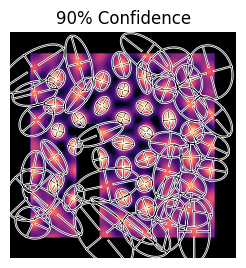

In [99]:
figure(figsize=(4,3));
showim(q); 
plot_peakbounds(pxy,P);

### Use sampling to assess the probability of a peak

We can also sample from the posterior distribution, and test how many of these samples have a certain property, e.g. having a peak at location $\mathbf x_0$.

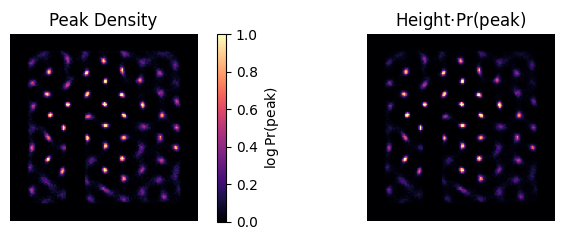

In [100]:
softmask = blur(mask,5,normalize=True)

def peak_density(w,Niter=1000):
    # w: posterior mean or mode vector
    # Ch: cholesky factor of log-posterior Hessian
    q = Qlr@randn(M2,Niter)
    q = (q+w2.ravel()[:,None]).reshape(L,L,Niter)
    q = (q-mean(mean(q,2)[mask]))*softmask[:,:,None]
    peaks = findpeaks(q,th=std(q))
    dnsty = mean(peaks,axis=2) + 1/Niter
    μhght = nan_to_num(sum(q*peaks,2)/sum(peaks,2))
    return dnsty,μhght

dnsty,μhght = peak_density(w2)
subplot(121); showim((dnsty),'Peak Density')
colorbar(label='$\log\,\Pr(\operatorname{peak})$')
subplot(122); showim(μhght*dnsty,'Height$\cdot\Pr$(peak)')
tight_layout()

In sum, we have illustrated the following workflow for analyzing firing rate maps for hippocampal grid cells: 

1. Bin spikes into a histogram of total number spikes and visits to each region
2. Use autocorrelation to estimate the grid scale
3. Use an idealized grid to set a prior for the log rate
4. Infer log-rate using kernel density estimation (KDE)
5. Use this KDE estimate as initializer for LGCP regression
6. Heuristically fit a log-Gaussian Cox process model using convolution
7. Identify grid field centers local maxima in the inferred rate map
8. Use the Laplace approximation to fit confidence regions for grid field centers 
9. Sample from the GP posterior to estimate the probability of a grid field center in each region

# Putting it all together

In this document, we discussed several ways to infer the underlying tuning of hippocampal grid cells. The methods outlines here will also work more generally, for any neuron tuned to a 2D feature space. 

Histogram-based estimators are easy, and work if low spatial resolution is acceptable. However, they need a lot of data to return a meaningful result. It's also hard to define notions of confidence for histograms. 

Kernel density estimators (KDEs) pool data from nearby regions. They are more efficient than Histograms, especially if one optimizes the kernel bandwidth to match the underlying variations in neuronal tuning. For moderate amounts of data, KDE estimators are fast, and return a reasonable estimate of the rate map. 

Gaussian process (GP) regression is more statistically efficient than KDE, and also estimates posterior covariance. This enables one to estimate confidence bounds for the inferred rate maps. GP regression requires solving a large linear system, but this can be accelerated using the minimum residual algorithm and calculating matrix products using the FFT. Sometimes, GP regression can be approximated by a convolution. 

Log-Gaussian Cox process (LGCP) regression is a generalization of GP regression. It infers the log-firing rate under a Poisson noise assumption, and returns good estimates from limited data. The computational cost of LGCP regression is only slightly higher than GP regression.

Overall, we illustrated several approaches to Gaussian-process regression to hippocampal grid cell data. We covered kernel density estimation, Gaussian process regression, and log-Gaussian Cox process regression. Throughout, we discussed practical issues necessary to achieve good performance, like using the FFT when possible, choosing numerically stable forms of the equations, and fast approximations based on convolution. Ultimately, we derived an FFT-based approximation to log-Gaussian Cox process regression. This provides an approach to analyzing grid cell data that is both statistically and computationally efficient.

# Appendix: numerical considerations in Gaussian Process (GP) and Log-Gaussian Cox Process (LGCP) regression

### Tricks for faster linear algebra

We use several tricks to speed up large matrix calculations

#### Matrix inversion and linear system solving using Cholesky factorization 

If a covariance matrix is non-singular (has no zero eigenvalues), then it is Positive Definite. This means it has a [Cholesky factorization](https://en.wikipedia.org/wiki/Cholesky_decomposition). The default behavior of `scipy.linalg.cholesky` is to return an upper-triangular matrix $Q$, for which: 

\begin{equation}
\begin{aligned}
Q &= \operatorname{chol}[\Sigma]
\\
\Sigma &= Q^\top Q
\end{aligned}
\end{equation}

The routine `scipy.linalg.lapack.dtrtri` will invert an upper-triangular matrix quickly. We can leverage this to invert the matrix $\Sigma$ efficiently.

\begin{equation}
\begin{aligned}
\Sigma^{-1} = (Q^{\top}Q)^{-1} = Q^{-1} Q^{-\top}
\end{aligned}
\end{equation}

We can also use Cholesky factorization to quickly solve the linear system $\Sigma^{-1}\mathbf u$

\begin{equation}
\begin{aligned}
\Sigma^{-1}\mathbf u &= Q^{-1} Q^{-\top} \mathbf u
\end{aligned}
\end{equation}

The routine `scipy.linalg.solve_triangular` can solve $Q^{-1}\mathbf v$ quickly for upper-triangular $Q$. Pass the `lower=True` argument to `solve_triangular` to calculate $\mathbf v = Q^{-\top} \mathbf u$ 

Cholesky decomposition and inverting a triangular matrix both have $\mathcal O(n^3)$, similarly to standard complexity for matrix multiplication and inversion, but has better constant factors. Once the Cholesky factor is computed, solving a linear system has complexity $\mathcal O(n^2)$. While this does not change the asymptotic complexity, constant factors are important. A $L\times L$ grid has $L^2$ regions, and a covariance matrix over $L^2$ elements has $L^4$ entries. A matrix operation that has $n^3$ complexity therefore costs $L^6$ in terms of the linear dimension of our 2D grid. 

### Multiplication using the Fast Fourier Transform (FFT)

Typically, our prior covariance kernel $\kappa(\mathbf x,\mathbf x')$ that is translationally invariant. When we evaluated on a periodic grid, the resulting prior $\Sigma_0$ is [circulant](https://en.wikipedia.org/wiki/Circulant_matrix). For circulant matrices, matrix inversion and multiplication can be done in $n\,\lg(n)$ time using the FFT, where $n$ is the number of points in our spatial grid. Denote the forward Fourier transform as the operator $\text F$, and the inverse Fourier transform as $\text F^{-1}$. Define the Fourier transform of our prior kernel as

\begin{equation}
\begin{aligned}
\tilde \kappa(\omega) &= \text F\, \kappa(\Delta \mathbf x).
\end{aligned}
\end{equation}

The Fourier transform coefficients $\tilde \kappa$ are the eigenvlues of $\Sigma_0$. If we choose the unitary definition of the Fourier transform, $\text F^{-1}=\text F^\dagger$, then $\text F$ is the eigenbasis of $\Sigma_0$:

\begin{equation}
\begin{aligned}
\Sigma_0 &= \text F\,\operatorname{diag}[\tilde\kappa]\,\text F^\dagger.
\end{aligned}
\end{equation}

The inverse $\Sigma_0^{-1}$ can therefore be calculated as 

\begin{equation}
\begin{aligned}
\Sigma_0^{-1} &= \text F\, \operatorname{diag}\left[1/{\tilde\kappa}\right]\,\text F^\dagger.
\end{aligned}
\end{equation}

The prodict $\Sigma_0 \mathbf u(\mathbf x)$ can be calculated via FFT using the convolution theorem:

\begin{equation}
\begin{aligned}
\Sigma_0 \mathbf u &= \kappa \otimes \mathbf u = \text F^\dagger\left[\tilde \kappa\circ{\operatorname F\mathbf u}\right],
\end{aligned}
\end{equation}

where $\circ$ is element-wise multiplication. Likewise, if all $\tilde\kappa$ are greater than zero, then the linear system $\Sigma_0^{-1}\mathbf u$ can be solved as

\begin{equation}
\begin{aligned}
\Sigma_0^{-1} \mathbf u &= \text F^\dagger\left[\tfrac{1}{\tilde \kappa}\circ{\operatorname F\mathbf u}\right].
\end{aligned}
\end{equation}

### Multiplication by a diagonal matrix is element-wise multiplication

If $D=\operatorname{diag}[\mathbf d]$ is a diagonal matrix, multiplication $D$ by vector $\mathbf u$ is simply an element-wise product:

\begin{equation}
\begin{aligned}
D\mathbf u &= \operatorname{diag}[\mathbf d\circ\mathbf u],
\end{aligned}
\end{equation}

And the matrix product $AD$ can be computed as a column-wise product

\begin{equation}
\begin{aligned}
D\mathbf u &= \operatorname{diag}[\mathbf d\circ\mathbf u]
\\
A D &= A \circ (\mathbf d {\tt1}^\top),
\end{aligned}
\end{equation}

where $\tt1$ is a column vector of ones. 

# Four ways to do Gaussian process regression 

### Form (a)

In most textbooks or tutorials you'll see the posterior mean written as:
    
\begin{equation}
\begin{aligned}
y_2 &\sim \mathcal N(\mu,\Sigma)
\\
\mu &= \mu_2 + \Sigma_{12}^\top[\Sigma_{11}+\Sigma_{\epsilon}]^{-1} (y_1 - \mu_1)
\\
\Sigma &= \Sigma_{22} - \Sigma_{12}^\top [\Sigma_{11}+\Sigma_{\epsilon}]^{-1} \Sigma_{12},
\end{aligned}
\end{equation}

where $\Sigma_{11}$ and $\Sigma_{22}$ are the prior covariance of the observation and output points, respectively; $\Sigma_{12}$ is the cross-covariance of the observation and output points; $\Sigma_{\epsilon}$ is the measurement noise covariance; $\mu_2$ and $\mu_1$ are the prior mean at the observation and output points, respectively, and $y_1$ are the observations. 

When observations are sparse, this form is computationally efficient efficient, because $\Sigma_{11}$ and $\Sigma_{\epsilon}$ are small, and the expression $\Sigma_{12}^\top [\Sigma_{11}+\Sigma_{\epsilon}]^{-1} \Sigma_{12}$ is low-rank. This form is especially convenient when updating a GP model with a single observation, in which case it reduces to a rank-1 update

\begin{equation}
\begin{aligned}
\mu &= \mu_2 + \tfrac{1}{\sigma^2_{11}+\sigma^2_{\epsilon}}\Sigma_{12}^\top (y_1 - \mu_1)
\\
\Sigma &= \Sigma_{22} - \tfrac{1}{\sigma^2_{11}+\sigma^2_{\epsilon}} \Sigma_{12}^\top \Sigma_{12}.
\end{aligned}
\end{equation}

However, in our application we have an extended time-series where a rat visits each location many times. There are many more observations than output points, and $\Sigma_{11}$ and $\Sigma_{\epsilon}$ are large matrices. Binning together nearby measurements reduces the complexity. However, coverage of the space is quite dense. $\Sigma_{11}$ and $\Sigma_{\epsilon}$ are almost as large as $\Sigma_{22}$, even excluding bins with no observations. We therefore assume that the observations and output points are evaluated on a common grid, in which case the equations take the form: 

\begin{equation}
\begin{aligned}
\mu &= \mu_0 + \Sigma_0^\top[\Sigma_0+\Sigma_{\epsilon}]^{-1} (y - \mu_0)
\\
\Sigma &= \Sigma_0 - \Sigma_0^\top [\Sigma_0+\Sigma_{\epsilon}]^{-1} \Sigma_0,
\end{aligned}
\tag{a}
\end{equation}

where $\Sigma_0$ $\mu_0$ are the prior covariance and mean, $\Sigma_\epsilon$ is the measurement error covariance, and $y$ are the measurements

**This form has the following useful properties:**

- $\Sigma_0$  and $\Sigma_\epsilon$ can be singular, provided  $\Sigma_0+\Sigma_\epsilon$ is not. In GP regression, this allows measurements with zero error, and also allows priors with zero eigenvalues. For example, one might set a prior that has zeros for high-frequency components, to encode a strong assumption that the posterior function should be smooth. 

- The update is low-rank and fast when observations are limited

- If $\Sigma_0+\Sigma_\epsilon$ is nonsingular, then it is positive definite. This allows one to compute $[\Sigma_0+\Sigma_\epsilon]^{-1}y$ quickly via Cholesky factorization. (However, it is even faster to use a Krylov subspace solver, if the prior $\Sigma_0$ is in a form that supports fast matrix-vector product via the FFT.)

- The final matrix multiplications by $\Sigma_0$ can be computed via FFT. (The data need to be zero padded to do this, but this padding can be stripped away after performing the convolution, so there is no added complexity cost. Contrast this to form b, in which the zero-padding must be retained before solving a linear system, which increases the complexity).

***Problem:*** This form is unsuitable if $\Sigma_\epsilon^{-1}$ is singular. In order to leverage the FFT for matrix calculations, we need to perform the GP regression over a regular and periodic grid. To avoid opposite ends of the space from interacting, we need to add as many zeros to the edge of our data as our kernel is wide. This means that, inherently, some bins will be missing data. Missing observations can be represented as zero precision (inverse variance), so $\Sigma_\epsilon^{-1}$ can be constructed—but it will not be invertable, so $\Sigma_\epsilon$ does not exist. 

### Form (b) 

It's also common to encounter the following form, when deriving the posterior mean for the product of two multivariate Gaussian distributions: 

\begin{equation}
\begin{aligned}
\mu
&=
\mu_0 + 
\left[\Sigma_0^{-1}+\Sigma_\epsilon^{-1}\right]^{-1} 
\Sigma_\epsilon^{-1} (y-\mu_0).
\end{aligned}
\tag{b}
\end{equation}

**This form has the following useful properties**

- $\Sigma_\epsilon^{-1}$ can be singular, so we can include "null" observations when calculating the regression over a regular grid
- $\Sigma_\epsilon^{-1} = \operatorname{diag}[\tau]$ is diagonal, so $\Sigma_\epsilon^{-1} y = \operatorname{diag}[\tau\circ y]$, which is trivial to compute
- If $\Sigma_0$ is nonsingular, then $\Sigma_0^{-1}$ exists and can be computed quickly via the FFT
- $\Sigma_0^{-1}+\Sigma_\epsilon^{-1}$ is positive definite. $\left[\Sigma_0^{-1}+\Sigma_\epsilon^{-1}\right]^{-1} \operatorname{diag}[\tau\circ y]$ can therefore be solve efficiently using Cholesky factorization. 
- Priors that assume correlations arise from nearest-neighbor interactions can be represented as a prior precision $\Sigma_0^{-1}$ that is nonzero only for entries for pairs of adjacent regions. This sparsity, when combined with Krylov subspace algorithms for solving the linear system, this allows for fast solutions on arbitrary topologies, for which spectral methods might not be possible. 

***Problem:*** This form is unsuitable if $\Sigma_0$ is singular, and is numerically unstable if $\Sigma_0$ is ill-conditioned. So, it requires regularization to ensure that no eigenvalue of $\Sigma_0$ is too small. For larger problems, it may require so much regularization that the prior $\Sigma_0$ is altered substantially, affecting the accuracy of the inferred posterior mean. Additionally, computing $\Sigma_0^{-1}$ via FFT requires adding zero padding to handle the circular boundary conditions correctly. This padding cannot be removed before solving the subsequent linear system without introducing boundary artifacts, so this can lead to slightly larger linear system to solve. Since the time complexity of this is $\mathcal O(L^6)$ in terms of the linear dimension of a $2\times 2$ grid, this can lead to a significant slowdown. 

### Form (c)

We can also pull out $\Sigma_0$ from form (b), and solve for the posterior mean as : 
    
\begin{equation}
\begin{aligned}
\mu &=\mu_0 + \left[\Sigma_0\Sigma_\epsilon^{-1} + I\right]^{-1} 
\left[
\Sigma_0\Sigma_\epsilon^{-1} (y-\mu_0)
\right].
\\
\end{aligned}
\tag{c}
\end{equation}

**This form has the following useful properties:**
    
- Both $\Sigma_0$ and $\Sigma_\epsilon^{-1}$ can be singular
- $\Sigma_\epsilon^{-1} y = \operatorname{diag}[\tau\circ y]$ is trivial, and $\Sigma_0 \operatorname{diag}[\tau\circ y]$ can be calculated via FFT
- The product $\Sigma_0\Sigma_\epsilon^{-1} = \Sigma_0\circ(\tau{\tt1}^\top)$ is trivial.
- $\Sigma_0\Sigma_\epsilon^{-1} + I$ is well conditioned, so this calculation is fairly numerically stable, requiring less regularization.
- If $\Sigma_0$ contains many zero eigenvalues, then it is *low rank*. In the special case that $\Sigma_0$ is circulant, the FFT offers a fast conversion to/from the eigenspace of $\Sigma_0$, and it is possible to use the nonzero Fourier components of $\Sigma_0$ as a low-rank basis for calculations.

***Problem:*** The matrix $\Sigma_0\Sigma_\epsilon^{-1} + I$ will not be symmetric in general, so we cannot use Cholesky factorization to solve the linear system here. This can lead to significant slow-downs for larger systems. However! Once $\Sigma_0\Sigma_\epsilon^{-1} y$ is computed via FFT, one can remove the zero-padding before solving the linear system, which reduces the problem size. Since computing circulant matrix operations using FFT requires as much zero-padding as our prior kernel is wide, this reduction in problem size can be significant. Since solving the linear system scales as $\mathcal O(L^6)$ for a $L\times L$ spatial grid, a small reduction in $L$ is much more important than the constant-factor improvement provided by Cholesky decomposition. 

Additionally, for translationally-invariant kernels on a regular grid, the matrix-vector product $[\Sigma_0\Sigma_\epsilon^{-1} + I]\mathbf u$ can be calculated quickly via FFT. This used with a Krylov-subspace-based solver like minres, and can be orders of magnitude faster than other approaches. 

### Form (d)

In the special case that the measurement error covariance is constant, $\Sigma_\epsilon = \sigma^2_\epsilon I$, then GP regression reduces to a convolution, and can be evaluated using the Fourier transform thanks to the convolution theorem: 

\begin{equation}
\begin{aligned}
\mu &= \mu_0 + \text F^{-1}\,\left[ \left(\frac{\tilde\kappa}{\tilde\kappa+\sigma^2_\epsilon}\right)\circ\text F\,(y-\mu_0)\right],
\end{aligned}
\tag{d}
\end{equation}

where $\text F$ is the Fourier transform. 

***Problem:*** The regression must be on a periodic domain in order to compute $\text F$ quickly using the FFT. This can cause measurements at opposite sides of the spatial grid to influence each-other. This can be solved by zero-padding. However, the above assumption assumes $\sigma^2_\epsilon$ for *all* observations, so this zero padding will also be treated as a $y=0$ observation with error $\sigma^2_\epsilon$. This will lead to some tapering toward zero at the boundaries. Alternatively, one may use reflected boundary conditions, copying a mirrored version of $y$ into the padded space. This reflected boundary condition reduces artifacts, but is not identical to solving the original, un-padded GP regression problem. 

Note: if $\Sigma_\epsilon$ is not constant, but changes slowly relative to the scale of the prior kernel, then one may also decompose a larger problem into smaller ones that tile the space.

### When to use which? 

Use form (a) when
- Measurement variance $\Sigma_\epsilon$ and prior covariance $\Sigma_\epsilon$ are well defined.
- Observations are sparse compared to the number of output points.
- This is as fast or faster than (b,c) for any size problem, but the extra matrix multiplications can be expensive for large systems, or when observations are dense. 

Use form (b) with when 
- The measurements and outputs are evaluated at the same set of points.
- $\Sigma_\epsilon^{-1}$ is well defined, but $\Sigma_\epsilon$ is not. 
- $\Sigma_0^{-1}$ exists and well-conditioned.
- For medium-sized systems,
    - $\Sigma_0^{-1}+\Sigma_\epsilon$ can be solved via Cholesky factorization.
- For large systems, use a Krylov subspace solver and leverage special properties of $\Sigma_0^{-1}$:
    - $\Sigma_0^{-1}$ is circulant, so we can use the FFT, *or*
    - $\Sigma_0^{-1}$ is sparse, arising from a nearest-neighbor model.

Use form (c) when 
- The measurements and outputs are taken at the same set of points
- $\Sigma_\epsilon^{-1}$ is well defined, but $\Sigma_\epsilon$ is not. 
- $\Sigma_0$ is low-rank so $\Sigma_0^{-1}$ does not exist.
- For large systems, use a Krylov subspace solver and leverage special properties of $\Sigma_0$:
  - If $\Sigma_0$ is circulant, use the FFT
  - Or, use a low-rank approximation $\Sigma_0=QQ^\top$

Use form (d) when
- The measurements and outputs are evaluated on a regular grid.
- The problem is too large to calculate using ordinary matrix operations
- Measurement error can be approximated as constant $\Sigma_\epsilon \approx \sigma^2_\epsilon I$
- Artifacts from zero or mirrored boundary conditions are acceptable, or the kernel is local and it is acceptable to discard the boundary regions.